

```
# Article: https://arxiv.org/pdf/2108.03358
# Source Code (original authors): https://github.com/shuwang127/PatchRNN
# Demo Code (original authors): https://github.com/shuwang127/PatchRNN-demo
# Run Initialisation once, after starting a new Environment in Colab
# Initialisation requires 16 GB RAM and can take a few minutes.
```

# Initialisation



## Helpers

In [ ]:
#STARTIGNORE - helper functions
import os
import requests
from pathlib import Path

def CreateDirectory(path):
  if os.path.exists(path):
    return
  else:
    os.mkdir(path)

def CreateFile(path, content, binary = False):
  if binary == True:
    with open(path, "wb") as f:
      f.write(content)
  else:
    with open(path, "w") as f:
      f.write(content)

def ReadFile(path):
    with open(path, "r", errors="replace") as f:
      return f.read()

def Download(url, dest):
  # Download helper functions from Learn PyTorch repo (if not already downloaded)
  if Path(f"{dest}").is_file():
    print(f"{dest} already exists, skipping download")
  else:
    print(f"Downloading {dest}")
    request = requests.get(url)
    CreateFile(dest,request.content,True)

def GetJsonFromURL(url,verbose=False):
  resp = requests.get(url)
  if verbose==True:
    print(resp)
    print(resp.text)
  return resp.json()

def GetTextFromURL(url,verbose=False):
  resp = requests.get(url)
  if verbose==True:
    print(resp)
    print(resp.text)
  return resp.text

def ReleaseGPUMemory():
  import gc
  import torch
  for i in range(5):
    torch.cuda.empty_cache()
    gc.collect()
    try:
      del model
    except:
      pass

def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__,
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned() else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__,
                                                   type(obj.data).__name__,
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned() else "",
                                                   " grad" if obj.requires_grad else "",
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass
    print("Total size:", total_size)
#ENDIGNORE



```
# Run this once, after starting a new Environment
# https://github.com/shuwang127/PatchRNN
```

## Data Fetch

In [ ]:
# Get the numpy arrays from repository
!git clone https://github.com/shuwang127/PatchRNN
!mv PatchRNN/analysis .
!mv PatchRNN/data .
!mv PatchRNN/temp .
!rm -r PatchRNN
!unzip -d data/negatives/ data/negatives/20200401N.zip && rm data/negatives/20200401N.zip
!unzip -d data/negatives/ data/negatives/20200512N.zip && rm data/negatives/20200512N.zip
!unzip -d data/negatives/ data/negatives/20200528N.zip && rm data/negatives/20200528N.zip
!unzip -d data/negatives/ data/negatives/20200603N.zip && rm data/negatives/20200603N.zip
!unzip -d data/negatives/ data/negatives/20200618N.zip && rm data/negatives/20200618N.zip
!unzip -d data/negatives/ data/negatives/20200707N.zip && rm data/negatives/20200707N.zip
!unzip -d data/positives/ data/positives/20200401P.zip && rm data/positives/20200401P.zip
!unzip -d data/positives/ data/positives/20200512P.zip && rm data/positives/20200512P.zip
!unzip -d data/positives/ data/positives/20200528P.zip && rm data/positives/20200528P.zip
!unzip -d data/positives/ data/positives/20200603P.zip && rm data/positives/20200603P.zip
!unzip -d data/positives/ data/positives/20200618P.zip && rm data/positives/20200618P.zip
!unzip -d data/positives/ data/positives/20200707P.zip && rm data/positives/20200707P.zip
!unzip -d temp temp/data.zip && rm temp/data.zip
!unzip -d temp temp/msgs.zip && rm temp/msgs.zip
!unzip -d temp temp/props.zip && rm temp/props.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: data/positives/20200618P/bonzini.qemu.7d2aabe262846ddeda1785d42ff4d7964e8ac1c8  
  inflating: data/positives/20200618P/bonzini.qemu.7feb640cf32d86f91f5a624136345eb6a63eab42  
  inflating: data/positives/20200618P/bonzini.qemu.a76f48e53382e6f039db6278443e3ce437653302  
  inflating: data/positives/20200618P/bonzini.qemu.a9ae2bffea62ce5158be7475fe41e5fba6d026c1  
  inflating: data/positives/20200618P/bonzini.qemu.c24135ffcc46ef1e02c69667f0b4156ebf7b86dd  
  inflating: data/positives/20200618P/bonzini.qemu.cc45995294b92d95319b4782750a3580cabdbc0c  
  inflating: data/positives/20200618P/bonzini.qemu.debfb917a4f9c0784772c86f110f2bcd22e5a14f  
  inflating: data/positives/20200618P/bonzini.qemu.e1c120a9c54872f8a538ff9129d928de4e865cbd  
  inflating: data/positives/20200618P/bonzini.qemu.e60baebd409d547292c778d599111ea1623dd4b5  
  inflating: data/positives/20200618P/bonzini.qemu.f34c9d6f10bd4d1c8abcf258e76fec739674a1

## Default Hyperparameters (global variables)



In [ ]:
# @title  {"display-mode":"code"}
# This section contains mostly unchanged code created by:
# Xinda Wang∗, Shu Wang∗, Pengbin Feng∗, Kun Sun∗, Sushil Jajodia∗, Sanae Benchaaboun†, and Frank Geck†∗Center for Secure Information Systems, George Mason University, Fairfax, VA, US† CSIA Division, C5ISR Center, Space and Terrestrial Communications Directorate,U.S. Army Combat Capabilities Development Command (DEVCOM)
# PatchRNN: A Deep Learning-Based System for Security Patch Identification
# Original code can be found here: https://github.com/shuwang127/PatchRNN-demo/tree/main/model
# Shared under Apache 2.0 license: https://github.com/shuwang127/PatchRNN-demo/tree/main?tab=Apache-2.0-1-ov-file#readme
# There might be minor changes that were necessary to port the original code to Transformer-based setup in later sections.

os.system('pip install clang')
import re
import gc
import math
import random
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import clang.cindex
import clang.enumerations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torchdata
from sklearn.metrics import accuracy_score

# environment settings.
_COLAB_ = 0 if (os.getenv('COLAB_GPU', 'NONE') == 'NONE') else 1 # 0 : Local environment, 1 : Google Colaboratory.
_COLAB_ = 0
# file paths.
rootPath = './drive/My Drive/Colab Notebooks/' if (_COLAB_) else './'
dataPath = rootPath + '/data/'
sDatPath = dataPath + '/security_patch/'
pDatPath = dataPath + '/positives/'
nDatPath = dataPath + '/negatives/'
tempPath = rootPath + '/temp/'

# hyper-parameters. (affect GPU memory size)
_DiffEmbedDim_  = 128       # 128
_DiffMaxLen_    = 600       # 200(0.7), 314(0.8), 609(0.9), 1100(0.95), 2200(0.98), 3289(0.99), 5000(0.995), 10000(0.9997)
_DRnnHidSiz_    = 16        # 16
_MsgEmbedDim_   = 128       # 128
_MsgMaxLen_     = 200       # 54(0.9), 78(0.95), 130(0.98), 187(0.99), 268(0.995), 356(0.998), 516(0.999), 1434(1)
_MRnnHidSiz_    = 32        # 16
_TwinEmbedDim_  = 128       # 128
_TwinMaxLen_    = 800       # 224(0.8), 425(0.9), 755(0.95), 1448(0.98), 2270(0.99)
_TRnnHidSiz_    = 32        # 16
# hyper-parameters. (affect training speed)
_DRnnBatchSz_   = 128       # 128
_DRnnLearnRt_   = 0.0001    # 0.0001
_MRnnBatchSz_   = 128       # 128
_MRnnLearnRt_   = 0.0001    # 0.0001
_PRnnBatchSz_   = 256       # 256
_PRnnLearnRt_   = 0.0005    # 0.0005
_TRnnBatchSz_   = 256       # 256
_TRnnLearnRt_   = 0.0005    # 0.0005
# hyper-parameters. (trivial network parameters, unnecessary to modify)
_DiffExtraDim_  = 2         # 2
_TwinExtraDim_  = 1         # 1
_DRnnHidLay_    = 1         # 1
_MRnnHidLay_    = 1         # 1
_TRnnHidLay_    = 1         # 1
# hyper-parameters. (epoch related parameters, unnecessary to modify)
_DRnnMaxEpoch_  = 1000      # 1000
_DRnnPerEpoch_  = 1         # 1
_DRnnJudEpoch_  = 10        # 10
_MRnnMaxEpoch_  = 1000      # 1000
_MRnnPerEpoch_  = 1         # 1
_MRnnJudEpoch_  = 10        # 10
_PRnnMaxEpoch_  = 1000      # 1000
_PRnnPerEpoch_  = 1         # 1
_PRnnJudEpoch_  = 10        # 10
_TRnnMaxEpoch_  = 1000      # 1000
_TRnnPerEpoch_  = 1         # 1
_TRnnJudEpoch_  = 10        # 10
# hyper-parameters. (flow control)
_DEBUG_ = 0 #  0 : release
            #  1 : debug
_LOCK_  = 0 #  0 : unlocked - create random split sets.
            #  1 : locked   - use the saved split sets.
_MODEL_ = 0 #  0 : unlocked - train a new model.
            #  1 : locked   - load the saved model.
_DTYP_  = 1 #  0 : maintain both diff code and context code.
            #  1 : only maintain diff code.
_CTYP_  = 0 #  0 : maintain both the code and comments.
            #  1 : only maintain code and delete comments.
_NIND_ =  1 # -1 : not abstract tokens. (and will disable _NLIT_)
            #  0 : abstract identifiers with VAR/FUNC.
            #  1 : abstract identifiers with VARn/FUNCn.
_NLIT_  = 1 #  0 : abstract literals with LITERAL.
            #  1 : abstract literals with LITERAL/n.
_TWIN_  = 1 #  0 : only twin neural network.
            #  1 : twins + msg neural network.

# print setting.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
np.set_printoptions(threshold=np.inf)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Codebase from original article

In [ ]:
# Copied from shuwang127/PatchRNN-demo
# @title SplitData
def SplitData(data, labels, setType, rate=0.2):
    '''
    Split the data and labels into two sets with a specific rate.
    :param data: feature data.
    [[[n, {0~5}, {-1~1}], ...], ...]
    [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, {-1~1}], ...], ...]
    :param labels: labels. [[0/1], ...]
    :param setType: the splited dataset type.
    :param rate: the split rate. 0 ~ 1
    :return: dsetRest - the rest dataset.
             lsetRest - the rest labels.
             dset - the splited dataset.
             lset - the splited labels.
    '''

    # set parameters.
    setType = setType.upper()
    numData = len(data)
    num = math.floor(numData * rate)

    # get the random data list.
    if (os.path.exists(tempPath + '/split_' + setType + '.npy')) & (_LOCK_):
        dataList = np.load(tempPath + '/split_' + setType + '.npy')
    else:
        dataList = list(range(numData))
        random.seed(10)
        random.shuffle(dataList)
        np.save(tempPath + '/split_' + setType + '.npy', dataList, allow_pickle=True)

    # split data.
    dset = data[dataList[0:num]]
    lset = labels[dataList[0:num]]
    dsetRest = data[dataList[num:]]
    lsetRest = labels[dataList[num:]]

    # print.
    setTypeRest = 'TRAIN' if (setType == 'VALID') else 'REST'
    print('[INFO] <SplitData> Split data into ' + str(len(dsetRest)) + ' ' + setTypeRest
          + ' dataset and ' + str(len(dset)) + ' ' + setType + ' dataset. (Total: '
          + str(len(dsetRest) + len(dset)) + ', Rate: ' + str(int(rate * 100)) + '%)')

    return dsetRest, lsetRest, dset, lset

In [ ]:
# @title TwinRNNTrain
def TwinRNNTrain(dTrain, lTrain, dValid, lValid, preWTwin, preWMsg, batchsize=64, learnRate=0.001, dTest=None, lTest=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinRNN model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    xTrain = torch.from_numpy(dTrain).long().cuda()
    yTrain = torch.from_numpy(lTrain).long().cuda()
    xValid = torch.from_numpy(dValid).long().cuda()
    yValid = torch.from_numpy(lValid).long().cuda()
    if (markTest):
        xTest = torch.from_numpy(dTest).long().cuda()
        yTest = torch.from_numpy(lTest).long().cuda()

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)
    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).cuda()

    # build the model of recurrent neural network.
    preWTwin = torch.from_numpy(preWTwin)
    preWMsg = torch.from_numpy(preWMsg)
    model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print('[INFO] <TwinRNNTrain> ModelType: TwinRNN.')
    print('[INFO] <TwinRNNTrain> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    print('[INFO] <TwinRNNTrain> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    print('[INFO] <TwinRNNTrain> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # run on each epoch.
    accList = [0]
    for epoch in range(_TRnnMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        for iter, (data, label) in enumerate(trainloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            loss.backward()
            optimizer.step()
            # statistic
            lossTrain += loss.item() * len(label)
            preds = yhat.max(1)[1]
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = yhat.max(1)[1]
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = yhat.max(1)[1]
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TRnnPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinRNN.pth')
        # stop judgement.
        if (epoch >= _TRnnJudEpoch_) and (accList[-1] < min(accList[-1-_TRnnJudEpoch_:-1])):
            break

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinRNN model. (Best model: ' + tempPath + '/model_TwinRNN.pth)')

    return model

In [ ]:
# @title ReadData
def ReadData():
    '''
    Read data from the files.
    :return: data - a set of commit message, diff code, and labels.
    [[['', ...], [['', ...], ['', ...], ...], 0/1], ...]
    '''

    def ReadCommitMsg(filename):
        '''
        Read commit message from a file.
        :param filename: file name (string).
        :return: commitMsg - commit message.
        ['line', 'line', ...]
        '''

        fp = open(filename, encoding='utf-8', errors='ignore')  # get file point.
        lines = fp.readlines()  # read all lines.
        #numLines = len(lines)   # get the line number.
        #print(lines)

        # initialize commit message.
        commitMsg = []
        # get the wide range of commit message.
        for line in lines:
            if line.startswith('diff --git'):
                break
            else:
                commitMsg.append(line)
        #print(commitMsg)
        # process the head of commit message.
        while (1):
            headMsg = commitMsg[0]
            if (headMsg.startswith('From') or headMsg.startswith('Date:') or headMsg.startswith('Subject:')
                    or headMsg.startswith('commit') or headMsg.startswith('Author:')):
                commitMsg.pop(0)
            else:
                break
        #print(commitMsg)
        # process the tail of commit message.
        dashLines = [i for i in range(len(commitMsg))
                     if commitMsg[i].startswith('---')]  # finds all lines start with ---.
        if (len(dashLines)):
            lnum = dashLines[-1]  # last line number of ---
            marks = [1 if (' file changed, ' in commitMsg[i] or ' files changed, ' in commitMsg[i]) else 0
                     for i in range(lnum, len(commitMsg))]
            if (sum(marks)):
                for i in reversed(range(lnum, len(commitMsg))):
                    commitMsg.pop(i)
        #print(commitMsg)

        #msgShow = ''
        #for i in range(len(commitMsg)):
        #    msgShow += commitMsg[i]
        #print(msgShow)

        return commitMsg

    def ReadDiffLines(filename):
        '''
        Read diff code from a file.
        :param filename:  file name (string).
        :return: diffLines - diff code.
        [['line', ...], ['line', ...], ...]
        '''

        fp = open(filename, encoding='utf-8', errors='ignore')  # get file point.
        lines = fp.readlines()  # read all lines.
        numLines = len(lines)  # get the line number.
        # print(filename)

        atLines = [i for i in range(numLines) if lines[i].startswith('@@ ')]  # find all lines start with @@.
        atLines.append(numLines)
        # print(atLines)

        diffLines = []
        for nh in range(len(atLines) - 1):  # find all hunks.
            # print(atLines[nh], atLines[nh + 1])
            hunk = []
            for nl in range(atLines[nh] + 1, atLines[nh + 1]):
                # print(lines[nl], end='')
                if lines[nl].startswith('diff --git '):
                    break
                else:
                    hunk.append(lines[nl])
            diffLines.append(hunk)
            # print(hunk)
        # print(diffLines)
        # print(len(diffLines))

        # process the last hunk.
        lastHunk = diffLines[-1]
        numLastHunk = len(lastHunk)
        dashLines = [i for i in range(numLastHunk) if lastHunk[i].startswith('--')]
        if (len(dashLines)):
            lnum = dashLines[-1]
            for i in reversed(range(lnum, numLastHunk)):
                lastHunk.pop(i)
        # print(diffLines)
        # print(len(diffLines))

        return diffLines

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'filelist.txt', 'w')

    # initialize data.
    data = []
    # read security patch data.
    for root, ds, fs in os.walk(sDatPath):
        for file in fs:
            filename = os.path.join(root, file).replace('\\', '/')
            fp.write(filename + '\n')
            commitMsg = ReadCommitMsg(filename)
            diffLines = ReadDiffLines(filename)
            data.append([commitMsg, diffLines, 1])

    # read positive data.
    for root, ds, fs in os.walk(pDatPath):
        for file in fs:
            filename = os.path.join(root, file).replace('\\', '/')
            fp.write(filename + '\n')
            commitMsg = ReadCommitMsg(filename)
            diffLines = ReadDiffLines(filename)
            data.append([commitMsg, diffLines, 1])

    # read negative data.
    for root, ds, fs in os.walk(nDatPath):
        for file in fs:
            filename = os.path.join(root, file).replace('\\', '/')
            fp.write(filename + '\n')
            commitMsg = ReadCommitMsg(filename)
            diffLines = ReadDiffLines(filename)
            data.append([commitMsg, diffLines, 0])
    fp.close()

    #print(len(dataLoaded))
    #print(len(dataLoaded[0]))
    #print(dataLoaded)
    # [[['a', 'b', 'c', ], [['', '', '', ], ['', '', '', ], ], 0/1], ]
    # sample = dataLoaded[i]
    # commitMsg = dataLoaded[i][0]
    # diffLines = dataLoaded[i][1]
    # label = dataLoaded[i][2]
    # diffHunk = dataLoaded[i][1][j]

    # save dataLoaded.
    if not os.path.exists(tempPath + '/data.npy'):
        np.save(tempPath + '/data.npy', data, allow_pickle=True)
        print('[INFO] <ReadData> Save ' + str(len(data)) + ' raw data to ' + tempPath + '/data.npy.')

    return data

In [ ]:
# @title GetDiffProps
def GetDiffProps(data):
    '''
    Get the properties of the code in diff files.
    :param data: [[[line, , ], [[line, , ], [line, , ], ...], 0/1], ...]
    :return: props - [[[tokens], [nums], [nums], 0/1], ...]
    '''

    def RemoveSign(line):
        '''
        Remove the sign (+/-) in the first character.
        :param line: a code line.
        :return: process line.
        '''

        return ' ' + line[1:] if (line[0] == '+') or (line[0] == '-') else line

    def GetClangTokens(line):
        '''
        Get the tokens of a line with the Clang tool.
        :param line: a code line.
        :return: tokens - ['tk', 'tk', ...] ('tk': string)
                 tokenTypes - [tkt, tkt, ...] (tkt: 1, 2, 3, 4, 5)
                 diffTypes - [dft, dft, ...] (dft: -1, 0, 1)
        '''

        # remove non-ascii
        line = line.encode("ascii", "ignore").decode()

        # defination.
        tokenClass = [clang.cindex.TokenKind.KEYWORD,      # 1
                      clang.cindex.TokenKind.IDENTIFIER,   # 2
                      clang.cindex.TokenKind.LITERAL,      # 3
                      clang.cindex.TokenKind.PUNCTUATION,  # 4
                      clang.cindex.TokenKind.COMMENT]      # 5
        tokenDict = {cls: index + 1 for index, cls in enumerate(tokenClass)}
        #print(tokenDict)

        # initialize.
        tokens = []
        tokenTypes = []
        diffTypes = []

        # clang sparser.
        idx = clang.cindex.Index.create()
        tu = idx.parse('tmp.cpp', args=['-std=c++11'], unsaved_files=[('tmp.cpp', RemoveSign(line))], options=0)
        for t in tu.get_tokens(extent=tu.cursor.extent):
            #print(t.kind, t.spelling, t.location)
            tokens.append(t.spelling)
            tokenTypes.append(tokenDict[t.kind])
            diffTypes.append(1 if (line[0] == '+') else -1 if (line[0] == '-') else 0)
        #print(tokens)
        #print(tokenTypes)
        #print(diffTypes)

        return tokens, tokenTypes, diffTypes

    def GetWordTokens(line):
        '''
        Get the word tokens from a code line.
        :param line: a code line.
        :return: tokens - ['tk', 'tk', ...] ('tk': string)
        '''

        tknzr = TweetTokenizer()
        tokens = tknzr.tokenize(RemoveSign(line))
        return tokens

    def GetString(lines):
        '''
        Get the strings from the diff code
        :param lines: diff code.
        :return: lineStr - All the diff lines.
                 lineStrB - The before-version code lines.
                 lineStrA - The after-version code lines.
        '''

        lineStr = ''
        lineStrB = ''
        lineStrA = ''
        for hunk in lines:
            for line in hunk:
                # all lines.
                lineStr += RemoveSign(line)
                # all Before lines.
                lineStrB += RemoveSign(line) if line[0] != '+' else ''
                # all After lines.
                lineStrA += RemoveSign(line) if line[0] != '-' else ''

        return lineStr, lineStrB, lineStrA

    def GetDiffTokens(lines):
        '''
        Get the tokens for the diff lines.
        :param lines: the diff code.
        :return: tokens - tokens ['tk', 'tk', ...] ('tk': string)
                 tokenTypes - token types [tkt, tkt, ...] (tkt: 1, 2, 3, 4, 5)
                 diffTypes - diff types [dft, dft, ...] (dft: -1, 0, 1)
        '''

        # initialize.
        tokens = []
        tokenTypes = []
        diffTypes = []

        # for each line of lines.
        for hunk in lines:
            for line in hunk:
                #print(line, end='')
                tk, tkT, dfT = GetClangTokens(line)
                tokens.extend(tk)
                tokenTypes.extend(tkT)
                diffTypes.extend(dfT)
                #print('-----------------------------------------------------------------------')
        #print(tokens)
        #print(tokenTypes)
        #print(diffTypes)

        return tokens, tokenTypes, diffTypes

    #lines = data[0][1]
    #print(lines)
    #hunk = data[0][1][0]
    #print(hunk)
    #line = data[0][1][0][0]
    #print(line)

    # for each sample data[n].
    numData = len(data)
    props = []
    for n in range(numData):
        # get the lines of the diff file.
        diffLines = data[n][1]
        # properties.
        tk, tkT, dfT = GetDiffTokens(diffLines)
        label = data[n][2]
        prop = [tk, tkT, dfT, label]
        #print(prop)
        props.append(prop)
        print(n)

    # save props.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    if not os.path.exists(tempPath + '/props.npy'):
        np.save(tempPath + '/props.npy', props, allow_pickle=True)
        print('[INFO] <GetDiffProps> Save ' + str(len(props)) + ' diff property data to ' + tempPath + '/props.npy.')

    return props

In [ ]:
# @title ProcessTokens
def ProcessTokens(props, dType=1, cType=1):
    '''
    only maintain the diff parts of the code.
    :param props: the features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    :param dType: 0 - maintain both diff code and context code.
                  1 - only maintain diff code.
    :param cType: 0 - maintain both the code and comments.
                  1 - only maintain code and delete comments.
    :return: props - the normalized features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    '''

    # process diff code.
    if (1 == dType):
        propsNew = []
        for item in props:
            # the number of tokens.
            numTokens = len(item[1])
            # item[0]: tokens, item[1]: tokenTypes, item[2]: diffTypes, item[3]: label.
            tokens = [item[0][n] for n in range(numTokens) if (item[2][n])]
            tokenTypes = [item[1][n] for n in range(numTokens) if (item[2][n])]
            diffTypes = [item[2][n] for n in range(numTokens) if (item[2][n])]
            label = item[3]
            # reconstruct sample.
            sample = [tokens, tokenTypes, diffTypes, label]
            propsNew.append(sample)
        props = propsNew
        print('[INFO] <ProcessTokens> Only maintain the diff parts of the code.')

    # process comments.
    if (1 == cType):
        propsNew = []
        for item in props:
            # the number of tokens.
            numTokens = len(item[1])
            # item[0]: tokens, item[1]: tokenTypes, item[2]: diffTypes, item[3]: label.
            tokens = [item[0][n] for n in range(numTokens) if (item[1][n] < 5)]
            tokenTypes = [item[1][n] for n in range(numTokens) if (item[1][n] < 5)]
            diffTypes = [item[2][n] for n in range(numTokens) if (item[1][n] < 5)]
            label = item[3]
            # reconstruct sample.
            sample = [tokens, tokenTypes, diffTypes, label]
            propsNew.append(sample)
        props = propsNew
        print('[INFO] <ProcessTokens> Delete the comment parts of the diff code.')

    #print(props[0])

    return props

In [ ]:
# @title AbstractTokens
def AbstractTokens(props, iType=1, lType=1):
    '''
    abstract the tokens of identifiers, literals, and comments.
    :param props: the features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    :param iType:   -1 - not abstract tokens.
                     0 - only abstract variable type and function type. VAR / FUNC
                     1 - abstract the identical variable names and function names.  VAR0, VAR1, ... / FUNC0, FUNC1, ...
    :param lType:   -1 - not abstract tokens.
                     0 - abstract literals with LITERAL.
                     1 - abstract literals with LITERAL/n.
    :return: props - the abstracted features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    '''

    if (iType not in [0, 1]) or (lType not in [0, 1]):
        print('[INFO] <AbstractTokens> Not abstract the tokens of identifiers, literals, and comments.')
        return props

    for item in props:
        # get tokens and token types.
        tokens = item[0]
        tokenTypes = item[1]
        numTokens = len(tokenTypes)
        #print(tokens)
        #print(tokenTypes)
        #print(numTokens)

        # abstract literals and comments, and separate identifiers into variables and functions.
        markVar = list(np.zeros(numTokens, dtype=int))
        markFuc = list(np.zeros(numTokens, dtype=int))
        for n in range(numTokens):
            # 2: IDENTIFIER, 3: LITERAL, 5: COMMENT
            if 5 == tokenTypes[n]:
                tokens[n] = 'COMMENT'
            elif 3 == tokenTypes[n]:
                if (0 == lType):
                    tokens[n] = 'LITERAL'
                elif (1 == lType):
                    if (not tokens[n].isdigit()):
                        tokens[n] = 'LITERAL'
            elif 2 == tokenTypes[n]:
                # separate variable name and function name.
                if (n < numTokens-1):
                    if (tokens[n+1] == '('):
                        markFuc[n] = 1
                    else:
                        markVar[n] = 1
                else:
                    markVar[n] = 1
        #print(tokens)
        #print(markVar)
        #print(markFuc)

        # abstract variables and functions.
        if (0 == iType):
            for n in range(numTokens):
                if 1 == markVar[n]:
                    tokens[n] = 'VAR'
                elif 1 == markFuc[n]:
                    tokens[n] = 'FUNC'
        elif (1 == iType):
            # get variable dictionary.
            varList = [tokens[idx] for idx, mark in enumerate(markVar) if mark == 1]
            varVoc  = {}.fromkeys(varList)
            varVoc  = list(varVoc.keys())
            varDict = {tk: 'VAR' + str(idx) for idx, tk in enumerate(varVoc)}
            # get function dictionary.
            fucList = [tokens[idx] for idx, mark in enumerate(markFuc) if mark == 1]
            fucVoc  = {}.fromkeys(fucList)
            fucVoc  = list(fucVoc.keys())
            fucDict = {tk: 'FUNC' + str(idx) for idx, tk in enumerate(fucVoc)}
            #print(varDict)
            #print(fucDict)
            for n in range(numTokens):
                if 1 == markVar[n]:
                    tokens[n] = varDict[tokens[n]]
                elif 1 == markFuc[n]:
                    tokens[n] = fucDict[tokens[n]]
    #print(tokens)
    print('[INFO] <AbstractTokens> Abstract the tokens of identifiers with iType ' + str(iType), end='')
    print(' (VAR/FUNC).') if (0 == iType) else print(' (VARn/FUNCn).')
    print('[INFO] <AbstractTokens> Abstract the tokens of literals, and comments with iType ' + str(lType), end='')
    print(' (LITERAL/COMMENT).') if (0 == lType) else print(' (LITERAL/n/COMMENT).')

    return props

In [ ]:
# @title GetDiffVocab
def GetDiffVocab(props):
    '''
    Get the vocabulary of diff tokens
    :param props - the features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    :return: vocab - the vocabulary of diff tokens. ['tk', 'tk', ...]
             maxLen - the max length of a diff code.
    '''

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'difflen.csv', 'w')

    # get the whole tokens and the max diff length.
    tokens = []
    maxLen = 0

    # for each sample.
    for item in props:
        tokens.extend(item[0])
        maxLen = len(item[0]) if (len(item[0]) > maxLen) else maxLen
        fp.write(str(len(item[0])) + '\n')
    fp.close()

    # remove duplicates and get vocabulary.
    vocab = {}.fromkeys(tokens)
    vocab = list(vocab.keys())

    # print.
    print('[INFO] <GetDiffVocab> There are ' + str(len(vocab)) + ' diff vocabulary tokens. (except \'<pad>\')')
    print('[INFO] <GetDiffVocab> The max diff length is ' + str(maxLen) + ' tokens. (hyperparameter: _DiffMaxLen_ = ' + str(_DiffMaxLen_) + ')')

    return vocab, maxLen

In [ ]:
# @title GetDiffDict
def GetDiffDict(vocab):
    '''
    Get the dictionary of diff vocabulary.
    :param vocab: the vocabulary of diff tokens. ['tk', 'tk', ...]
    :return: tokenDict - the dictionary of diff vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    '''

    # get token dict from vocabulary.
    tokenDict = {token: (index+1) for index, token in enumerate(vocab)}
    tokenDict['<pad>'] = 0

    # print.
    print('[INFO] <GetDiffDict> Create dictionary for ' + str(len(tokenDict)) + ' diff vocabulary tokens. (with \'<pad>\')')

    return tokenDict

In [ ]:
# @title GetDiffEmbed
def GetDiffEmbed(tokenDict, embedSize):
    '''
    Get the pre-trained weights for embedding layer from the dictionary of diff vocabulary.
    :param tokenDict: the dictionary of diff vocabulary.
    {'tk': 0, 'tk': 1, ..., '<pad>': N}
    :param embedSize: the dimension of the embedding vector.
    :return: preWeights - the pre-trained weights for embedding layer.
    [[n, ...], [n, ...], ...]
    '''

    # number of the vocabulary tokens.
    numTokens = len(tokenDict)

    # initialize the pre-trained weights for embedding layer.
    preWeights = np.zeros((numTokens, embedSize))
    for index in range(numTokens):
        preWeights[index] = np.random.normal(size=(embedSize,))
    print('[INFO] <GetDiffEmbed> Create pre-trained embedding weights with ' + str(len(preWeights)) + ' * ' + str(len(preWeights[0])) + ' matrix.')

    # save preWeights.
    if not os.path.exists(tempPath + '/preWeights.npy'):
        np.save(tempPath + '/preWeights.npy', preWeights, allow_pickle=True)
        print('[INFO] <GetDiffEmbed> Save the pre-trained weights of embedding layer to ' + tempPath + '/preWeights.npy.')

    return preWeights

In [ ]:
# @title DivideBeforeAfter
def DivideBeforeAfter(diffProps):

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'twinlen.csv', 'w')

    twinProps = []
    maxLen = 0
    # for each sample in diffProps.
    for item in diffProps:
        # get the tk, tkT, dfT, lb.
        tokens = item[0]
        tokenTypes = item[1]
        diffTypes = item[2]
        label = item[3]
        numTokens = len(diffTypes)
        # reconstruct tkB, tkTB, tkA, tkTA.
        tokensB = [tokens[i] for i in range(numTokens) if (diffTypes[i] <= 0)]
        tokenTypesB = [tokenTypes[i] for i in range(numTokens) if (diffTypes[i] <= 0)]
        tokensA = [tokens[i] for i in range(numTokens) if (diffTypes[i] >= 0)]
        tokenTypesA = [tokenTypes[i] for i in range(numTokens) if (diffTypes[i] >= 0)]
        # reconstruct new sample.
        sample = [tokensB, tokenTypesB, tokensA, tokenTypesA, label]
        twinProps.append(sample)
        # get max length.
        maxLenAB = max(len(tokenTypesB), len(tokenTypesA))
        maxLen = maxLenAB if (maxLen < maxLenAB) else maxLen
        fp.write(str(len(tokenTypesB)) + '\n')
        fp.write(str(len(tokenTypesA)) + '\n')
    fp.close()

    #print(twinProps[0])
    #print(maxLen)

    # print.
    print('[INFO] <DivideBeforeAfter> Divide diff code into BEFORE-version and AFTER-version code.')
    print('[INFO] <DivideBeforeAfter> The max length in BEFORE/AFTER-version code is ' + str(maxLen) + ' tokens. (hyperparameter: _TwinMaxLen_ = ' + str(_TwinMaxLen_) + ')')

    return twinProps, maxLen

In [ ]:
# @title GetTwinMapping
def GetTwinMapping(props, maxLen, tokenDict):
    '''
    Map the feature data into indexed data.
    :param props: the features of diff code.
    [[[tokens], [nums], [tokens], [nums], 0/1], ...]
    :param maxLen: the max length of a twin code.
    :param tokenDict: the dictionary of diff vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    :return: np.array(data) - feature data.
             [[[n, {0~5}, n, {0~5}], ...], ...]
             np.array(labels) - labels.
             [[0/1], ...]
    '''

    def PadList(dList, pad, length):
        '''
        Pad the list data to a fixed length.
        :param dList: the list data - [ , , ...]
        :param pad: the variable used to pad.
        :param length: the fixed length.
        :return: dList - padded list data. [ , , ...]
        '''

        if len(dList) <= length:
            dList.extend(pad for i in range(length - len(dList)))
        elif len(dList) > length:
            dList = dList[0:length]

        return dList

    # initialize the data and labels.
    data = []
    labels = []

    # for each sample.
    for item in props:
        # initialize sample.
        sample = []

        # process tokensB.
        tokens = item[0]
        tokens = PadList(tokens, '<pad>', maxLen)
        tokens2index = []
        for tk in tokens:
            tokens2index.append(tokenDict[tk])
        sample.append(tokens2index)
        # process tokenTypesB.
        tokenTypes = item[1]
        tokenTypes = PadList(tokenTypes, 0, maxLen)
        sample.append(tokenTypes)
        # process tokensA.
        tokens = item[2]
        tokens = PadList(tokens, '<pad>', maxLen)
        tokens2index = []
        for tk in tokens:
            tokens2index.append(tokenDict[tk])
        sample.append(tokens2index)
        # process tokenTypesA.
        tokenTypes = item[3]
        tokenTypes = PadList(tokenTypes, 0, maxLen)
        sample.append(tokenTypes)

        # process sample.
        sample = np.array(sample).T
        data.append(sample)
        # process label.
        label = item[4]
        labels.append([label])

    if _DEBUG_:
        print('[DEBUG] data:')
        print(data[0:3])
        print('[DEBUG] labels:')
        print(labels[0:3])

    # print.
    print('[INFO] <GetTwinMapping> Create ' + str(len(data)) + ' feature data with ' + str(len(data[0])) + ' * ' + str(len(data[0][0])) + ' matrix.')
    print('[INFO] <GetTwinMapping> Create ' + str(len(labels)) + ' labels with 1 * 1 matrix.')

    # save files.
    if (not os.path.exists(tempPath + '/tdata_' + str(maxLen) + '.npy')) \
            | (not os.path.exists(tempPath + '/tlabels_' + str(maxLen) + '.npy')):
        np.save(tempPath + '/tdata_' + str(maxLen) + '.npy', data, allow_pickle=True)
        print('[INFO] <GetTwinMapping> Save the mapped numpy data to ' + tempPath + '/tdata_' + str(maxLen) + '.npy.')
        np.save(tempPath + '/tlabels_' + str(maxLen) + '.npy', labels, allow_pickle=True)
        print('[INFO] <GetTwinMapping> Save the mapped numpy labels to ' + tempPath + '/tlabels_' + str(maxLen) + '.npy.')

    return np.array(data), np.array(labels)

In [ ]:
# @title UpdateTwinTokenTypes
def UpdateTwinTokenTypes(data):
    '''
    Update the token type in the feature data into one-hot vector.
    :param data: feature data. [[[n, {0~5}, n, {0~5},], ...], ...]
    :return: np.array(newData). [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, n, 0/1, 0/1, 0/1, 0/1, 0/1], ...], ...]
    '''

    newData = []
    # for each sample.
    for item in data:
        # get the transpose of props.
        itemT = item.T
        # initialize new sample.
        newItem = []
        newItem.append(itemT[0])
        newItem.extend(np.zeros((5, len(item)), dtype=int))
        newItem.append(itemT[2])
        newItem.extend(np.zeros((5, len(item)), dtype=int))
        # assign the new sample.
        for i in range(len(item)):
            tokenType = itemT[1][i]
            if (tokenType):
                newItem[tokenType][i] = 1
            tokenType = itemT[3][i]
            if (tokenType):
                newItem[tokenType+6][i] = 1
        # get the transpose of new sample.
        newItem = np.array(newItem).T
        # append new sample.
        newData.append(newItem)

    if _DEBUG_:
        print('[DEBUG] newData:')
        print(newData[0:3])

    # print.
    print('[INFO] <UpdateTwinTokenTypes> Update ' + str(len(newData)) + ' feature data with ' + str(len(newData[0])) + ' * ' + str(len(newData[0][0])) + ' matrix.')

    # save files.
    if (not os.path.exists(tempPath + '/newtdata_' + str(len(newData[0])) + '.npy')):
        np.save(tempPath + '/newtdata_' + str(len(newData[0])) + '.npy', newData, allow_pickle=True)
        print('[INFO] <UpdateTwinTokenTypes> Save the mapped numpy data to ' + tempPath + '/newtdata_' + str(len(newData[0])) + '.npy.')

    # change marco.
    global _TwinExtraDim_
    _TwinExtraDim_ = 5

    return np.array(newData)

In [ ]:
# @title GetCommitMsgs
def GetCommitMsgs(data):
    '''
    Get the commit messages in diff files.
    :param data: [[[line, , ], [[line, , ], [line, , ], ...], 0/1], ...]
    :return: msgs - [[[tokens], 0/1], ...]
    '''

    def GetMsgTokens(lines):
        '''
        Get the tokens from a commit message.
        :param lines: commit message. [line, , ]
        :return: tokensStem ['tk', , ]
        '''

        # concatenate lines.
        # get the string of commit message.
        msg = ''
        for line in lines:
            msg += line[:-1] + ' '
        #print(msg)

        # pre-process.
        # remove url.
        pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        msg = re.sub(pattern, ' ', msg)
        # remove independent numbers.
        pattern = r' \d+ '
        msg = re.sub(pattern, ' ', msg)
        # lower case capitalized words.
        pattern = r'([A-Z][a-z]+)'
        def LowerFunc(matched):
            return matched.group(1).lower()
        msg = re.sub(pattern, LowerFunc, msg)
        # remove footnote.
        patterns = ['signed-off-by:', 'reported-by:', 'reviewed-by:', 'acked-by:', 'found-by:', 'tested-by:', 'cc:']
        for pattern in patterns:
            index = msg.find(pattern)
            if (index > 0):
                msg = msg[:index]
        #print(msg)

        # clearance.
        # get the tokens.
        tknzr = TweetTokenizer()
        tokens = tknzr.tokenize(msg)
        # clear tokens that don't contain any english letter.
        for i in reversed(range(len(tokens))):
            if not (re.search('[a-z]', tokens[i])):
                tokens.pop(i)
        # clear tokens that are stopwords.
        for i in reversed(range(len(tokens))):
            if (tokens[i] in stopwords.words('english')):
                tokens.pop(i)
        pattern = re.compile("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
        for i in reversed(range(len(tokens))):
            if (pattern.findall(tokens[i])):
                tokens.pop(i)
        #print(tokens)

        # process tokens with stemming.
        porter = PorterStemmer()
        tokensStem = []
        for item in tokens:
            tokensStem.append(porter.stem(item))
        #print(tokensStem)

        return tokensStem

    # for each sample data[n].
    numData = len(data)
    msgs = []
    for n in range(numData):
        # get the lines of the commit message.
        commitMsg = data[n][0]
        mtk = GetMsgTokens(commitMsg)
        # get the label.
        label = data[n][2]
        #print([mtk, label])
        # append the message tokens.
        msgs.append([mtk, label])
        print(n)

    # save commit messages.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    if not os.path.exists(tempPath + '/msgs.npy'):
        np.save(tempPath + '/msgs.npy', msgs, allow_pickle=True)
        print('[INFO] <GetCommitMsg> Save ' + str(len(msgs)) + ' commit messages to ' + tempPath + '/msgs.npy.')

    return msgs

In [ ]:
# @title GetMsgVocab
def GetMsgVocab(msgs):
    '''
    Get the vocabulary of message tokens
    :param msgs - [[[tokens], 0/1], ...]
    :return: vocab - the vocabulary of message tokens. ['tk', 'tk', ...]
             maxLen - the max length of a commit message.
    '''

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'msglen.csv', 'w')

    # get the whole tokens and the max msg length.
    tokens = []
    maxLen = 0

    # for each sample.
    for item in msgs:
        tokens.extend(item[0])
        maxLen = len(item[0]) if (len(item[0]) > maxLen) else maxLen
        fp.write(str(len(item[0])) + '\n')
    fp.close()

    # remove duplicates and get vocabulary.
    vocab = {}.fromkeys(tokens)
    vocab = list(vocab.keys())

    # print.
    print('[INFO] <GetMsgVocab> There are ' + str(len(vocab)) + ' commit message vocabulary tokens. (except \'<pad>\')')
    print('[INFO] <GetMsgVocab> The max msg length is ' + str(maxLen) + ' tokens. (hyperparameter: _MsgMaxLen_ = ' + str(_MsgMaxLen_) + ')')

    return vocab, maxLen

In [ ]:
# @title GetMsgDict
def GetMsgDict(vocab):
    '''
    Get the dictionary of msg vocabulary.
    :param vocab: the vocabulary of msg tokens. ['tk', 'tk', ...]
    :return: tokenDict - the dictionary of msg vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    '''

    # get token dict from vocabulary.
    tokenDict = {token: (index+1) for index, token in enumerate(vocab)}
    tokenDict['<pad>'] = 0

    # print.
    print('[INFO] <GetMsgDict> Create dictionary for ' + str(len(tokenDict)) + ' msg vocabulary tokens. (with \'<pad>\')')

    return tokenDict

In [ ]:
# @title GetMsgEmbed
def GetMsgEmbed(tokenDict, embedSize):
    '''
    Get the pre-trained weights for embedding layer from the dictionary of msg vocabulary.
    :param tokenDict: the dictionary of msg vocabulary.
    {'tk': 0, 'tk': 1, ..., '<pad>': N}
    :param embedSize: the dimension of the embedding vector.
    :return: preWeights - the pre-trained weights for embedding layer.
    [[n, ...], [n, ...], ...]
    '''

    # number of the vocabulary tokens.
    numTokens = len(tokenDict)

    # initialize the pre-trained weights for embedding layer.
    preWeights = np.zeros((numTokens, embedSize))
    for index in range(numTokens):
        preWeights[index] = np.random.normal(size=(embedSize,))
    print('[INFO] <GetMsgEmbed> Create pre-trained embedding weights with ' + str(len(preWeights)) + ' * ' + str(len(preWeights[0])) + ' matrix.')

    # save preWeights.
    if not os.path.exists(tempPath + '/msgPreWeights.npy'):
        np.save(tempPath + '/msgPreWeights.npy', preWeights, allow_pickle=True)
        print('[INFO] <GetMsgEmbed> Save the pre-trained weights of embedding layer to ' + tempPath + '/msgPreWeights.npy.')

    return preWeights

In [ ]:
# @title GetMsgMapping
def GetMsgMapping(msgs, maxLen, tokenDict):
    '''
    Map the feature data into indexed data.
    :param props: the features of commit messages.
    [[[tokens], 0/1], ...]
    :param maxLen: the max length of the commit message.
    :param tokenDict: the dictionary of commit message vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    :return: np.array(data) - feature data.
             [[n, ...], ...]
             np.array(labels) - labels.
             [[0/1], ...]
    '''

    def PadList(dList, pad, length):
        '''
        Pad the list data to a fixed length.
        :param dList: the list data - [ , , ...]
        :param pad: the variable used to pad.
        :param length: the fixed length.
        :return: dList - padded list data. [ , , ...]
        '''

        if len(dList) <= length:
            dList.extend(pad for i in range(length - len(dList)))
        elif len(dList) > length:
            dList = dList[0:length]

        return dList

    # initialize the data and labels.
    data = []
    labels = []

    # for each sample.
    for item in msgs:
        # process tokens.
        tokens = item[0]
        tokens = PadList(tokens, '<pad>', maxLen)
        # convert tokens into numbers.
        tokens2index = []
        for tk in tokens:
            tokens2index.append(tokenDict[tk])
        data.append(tokens2index)
        # process label.
        label = item[1]
        labels.append([label])

    if _DEBUG_:
        print('[DEBUG] data:')
        print(data[0:3])
        print('[DEBUG] labels:')
        print(labels[0:3])

    # print.
    print('[INFO] <GetMsgMapping> Create ' + str(len(data)) + ' feature data with 1 * ' + str(len(data[0])) + ' vector.')
    print('[INFO] <GetMsgMapping> Create ' + str(len(labels)) + ' labels with 1 * 1 matrix.')

    # save files.
    if (not os.path.exists(tempPath + '/mdata_' + str(maxLen) + '.npy')) \
            | (not os.path.exists(tempPath + '/mlabels_' + str(maxLen) + '.npy')):
        np.save(tempPath + '/mdata_' + str(maxLen) + '.npy', data, allow_pickle=True)
        print('[INFO] <GetMsgMapping> Save the mapped numpy data to ' + tempPath + '/mdata_' + str(maxLen) + '.npy.')
        np.save(tempPath + '/mlabels_' + str(maxLen) + '.npy', labels, allow_pickle=True)
        print('[INFO] <GetMsgMapping> Save the mapped numpy labels to ' + tempPath + '/mlabels_' + str(maxLen) + '.npy.')

    return np.array(data), np.array(labels)

In [ ]:
# @title CombineTwinMsgs
def CombineTwinMsgs(props, msgs, plabels, mlabels):
    '''
    Combine the twin props with the commit messages.
    :param props: twin data. [[[n, {0~5}, n, {0~5}], ...], ...] or [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, n, 0/1, 0/1, 0/1, 0/1, 0/1], ...], ...]
    :param msgs: message data. [[n, ...], ...]
    :param plabels: twin labels. [[0/1], ...]
    :param mlabels: message labels. [[0/1], ...]
    :return: np.array(data) - combined data. [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, n, 0/1, 0/1, 0/1, 0/1, 0/1, n], ...], ...]
             np.array(plabels) - combined labels. [[0/1], ...]
    '''

    # check the lengths.
    if (len(plabels) != len(mlabels)):
        print('[ERROR] <CombineTwinMsgs> the data lengths are mismatch.')
        return [[]], [[]]

    # check the labels.
    cntMatch = 0
    for n in range(len(plabels)):
        if (plabels[n][0] == mlabels[n][0]):
            cntMatch += 1
    if (cntMatch != len(plabels)):
        print('[ERROR] <CombineTwinMsgs> the labels are mismatch. ' + str(cntMatch) + '/' + str(len(plabels)) + '.')
        return [[]], [[]]

    #print(props[1], len(props[1]))
    #print(msgs[1], len(msgs[1]))

    data = []
    for n in range(len(plabels)):
        # get the twin prop and message.
        prop = props[n]
        msg = msgs[n]
        # pad data.
        if (_TwinMaxLen_ >= _MsgMaxLen_):
            msg = np.pad(msg, (0, _TwinMaxLen_ - _MsgMaxLen_), 'constant')
        else:
            prop = np.pad(prop, ((0, _MsgMaxLen_ - _TwinMaxLen_), (0, 0)), 'constant')
        #print(msg, len(msg))
        #print(prop, len(prop))
        # reconstruct sample.
        sample = np.vstack((prop.T, msg))
        # append the sample to data.
        data.append(sample.T)

    if _DEBUG_:
        print(np.array(data[0:3]))

    print('[INFO] <CombineTwinMsgs> Combine the twin props with the commit messages.')

    return np.array(data), np.array(plabels)

In [ ]:
# @title OutputEval
def OutputEval(predictions, labels, method=''):
    '''
    Output the evaluation results.
    :param predictions: predicted labels. [[0], [1], ...]
    :param labels: ground truth labels. [[1], [1], ...]
    :param method: method name. string
    :return: accuracy - the total accuracy. numeric
             confusion - confusion matrix [[1000, 23], [12, 500]]
    '''

    # evaluate the predictions with gold labels, and get accuracy and confusion matrix.
    def Evaluation(predictions, labels):

        # parameter settings.
        D = len(labels)
        cls = 2

        # get confusion matrix.
        confusion = np.zeros((cls, cls))
        for ind in range(D):
            nRow = int(predictions[ind][0])
            nCol = int(labels[ind][0])
            confusion[nRow][nCol] += 1

        # get accuracy.
        accuracy = 0
        for ind in range(cls):
            accuracy += confusion[ind][ind]
        accuracy /= D

        return accuracy, confusion

    # get accuracy and confusion matrix.
    accuracy, confusion = Evaluation(predictions, labels)
    precision = confusion[1][1] / (confusion[1][0] + confusion[1][1]) if (confusion[1][0] + confusion[1][1]) else 0
    recall = confusion[1][1] / (confusion[0][1] + confusion[1][1]) if (confusion[0][1] + confusion[1][1]) else 0
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # output on screen and to file.
    print('       -------------------------------------------')
    print('       method           :  ' +  method) if len(method) else print('', end='')
    print('       accuracy  (ACC)  :  %.3f%%' % (accuracy * 100))
    print('       precision (P)    :  %.3f%%' % (precision * 100))
    print('       recall    (R)    :  %.3f%%' % (recall * 100))
    print('       F1 score  (F1)   :  %.3f' % (F1))
    print('       fall-out  (FPR)  :  %.3f%%' % (confusion[1][0] * 100 / (confusion[1][0] + confusion[0][0])))
    print('       miss rate (FNR)  :  %.3f%%' % (confusion[0][1] * 100 / (confusion[0][1] + confusion[1][1])))
    print('       confusion matrix :      (actual)')
    print('                           Neg         Pos')
    print('       (predicted) Neg     %-5d(TN)   %-5d(FN)' % (confusion[0][0], confusion[0][1]))
    print('                   Pos     %-5d(FP)   %-5d(TP)' % (confusion[1][0], confusion[1][1]))
    print('       -------------------------------------------')

    return accuracy, confusion

##

```
# Sformatowano jako kod
```

 Loading data to memory

In [ ]:
# load data.
if (not os.path.exists(tempPath + '/data.npy')):  # | (not _DEBUG_)
    dataLoaded = ReadData()
else:
    dataLoaded = np.load(tempPath + '/data.npy', allow_pickle=True)
    print('[INFO] <ReadData> Load ' + str(len(dataLoaded)) + ' raw data from ' + tempPath + '/data.npy.')

# get the diff file properties.
if (not os.path.exists(tempPath + '/props.npy')):
    diffProps = GetDiffProps(dataLoaded)
else:
    diffProps = np.load(tempPath + '/props.npy', allow_pickle=True)
    print('[INFO] <GetDiffProps> Load ' + str(len(diffProps)) + ' diff property data from ' + tempPath + '/props.npy.')
# maintain both the context and diff parts. Delete comments.
diffProps = ProcessTokens(diffProps, dType=0, cType=_CTYP_)
# normalize the tokens of identifiers (VARn/FUNCn), literals (LITERAL/n), and comments (none).
diffProps = AbstractTokens(diffProps, iType=_NIND_, lType=_NLIT_)
# get the diff token vocabulary.
diffVocab, _ = GetDiffVocab(diffProps)
# TS: Noting exceptional up to this point. :TS
# get the diff token dictionary.
diffDict = GetDiffDict(diffVocab)
# TS:
# diffDict contains encodings based on the input code. It's not extensible for new keyword tokens at this point. E.g  while is encoded as 1
# List of standard key-value pairs where k:str and v:int
# :TS
# get pre-trained weights for embedding layer.
twinPreWeights = GetDiffEmbed(diffDict, _TwinEmbedDim_)
# divide diff code into before/after-version code.
twinProps, twinMaxLen = DivideBeforeAfter(diffProps)
# TS: At this point twinProps are in the following format
# every item in twinProps is a list of 4 items
# [[beforestr1,...,beforestrN] , [beforestrType1,...,beforestrType1] , [afterstr1,...,afterstrN] , [afterstrType1,...,afterstrTypeN]]
# where beforestr1 can be e.g while and thus beforestrType1 will be 1 (1 == keyword)
# :TS
# get the max twin length.
twinMaxLen = _TwinMaxLen_ if (twinMaxLen > _DiffMaxLen_) else twinMaxLen
# get the mapping for feature data and labels.
twinData, twinLabels = GetTwinMapping(twinProps, twinMaxLen, diffDict)
# TS:
# At this point every item in twinData is a 2-d array:
# [[encodedtoken0B, encodedtokenType0B, encodedtoken0A, encodedTokenType0A], ..., [encodedtokenNB, encodedtokenTypeNB, encodedtokenNA, encodedTokenTypeNA]
# The lenghts are 'padded'
# :TS
# change the tokentypes into one-hot vector.
twinData = UpdateTwinTokenTypes(twinData)
# TS: Note that this encodes only token-types, the tokenID remains an integer value, which is fine, because then we have embeddings:
# e.g: [[ 1  1  0  0  0  0  1  1  0  0  0  0],
# [ 2  0  0  0  1  0  2  0  0  0  1  0],
# [ 3  0  0  0  1  0  3  0  0  0  1  0]....
# Each row is [tokenB 5x tokenTypeB.onehot tokenA tokenTypeA.onehot]
# get the commit messages from data.
if (not os.path.exists(tempPath + '/msgs.npy')):
    commitMsgs = GetCommitMsgs(dataLoaded)
else:
    commitMsgs = np.load(tempPath + '/msgs.npy', allow_pickle=True)
    print('[INFO] <GetCommitMsg> Load ' + str(len(commitMsgs)) + ' commit messages from ' + tempPath + '/msgs.npy.')
# TS: Loaded messages are only key words + label, they are no longer structured like a normal message.
# e.g: [list(['dv', 'fix', 'null', 'pointer', 'derefer', 'due', 'ach', 'fix', 'part']) 1]
# :TS
# get the message token vocabulary.
msgVocab, msgMaxLen = GetMsgVocab(commitMsgs)
# get the max msg length.
msgMaxLen = _MsgMaxLen_ if (msgMaxLen > _MsgMaxLen_) else msgMaxLen
# get the msg token dictionary.
# TS: Every token found in messages is converted to dict (it's not just words, they are detected in more elaborate fashion, for example word 'architecture' becomes 'architectur')
# :TS
msgDict = GetMsgDict(msgVocab)
# TS: Straightforward "token" to "int"
# :TS
# get pre-trained weights for embedding layer.
msgPreWeights = GetMsgEmbed(msgDict, _MsgEmbedDim_)
# get the mapping for feature data and labels.
msgData, msgLabels = GetMsgMapping(commitMsgs, msgMaxLen, msgDict)
# TS:
# msgData items are just lists of tokens. (padded and not one-hot encoded, which is fine, because then we we have embeddings)
# [ 1  2  3  4  5  6  7  8  3  4  9 10 11 12 13 14 15  3  4  0  0  0 ... padding .... 0]
# :TS
# combine the twin data with the message data.
data, label = CombineTwinMsgs(twinData, msgData, twinLabels, msgLabels)
# TS:
# Every data item is the following:
#[[ 4  0  1  0  0  0  4  0  1  0  0  0  1]
# [21  0  0  0  1  0 21  0  0  0  1  0  2]
# ....
# [[tokenB, 5x one-hotTypeB, tokenA, 5x one-hotTypeA, msgToken]....
# Last column is simply message tokens encoded
# :TS

[INFO] <ReadData> Load 38041 raw data from .//temp//data.npy.
[INFO] <GetDiffProps> Load 38041 diff property data from .//temp//props.npy.
[INFO] <AbstractTokens> Abstract the tokens of identifiers with iType 1 (VARn/FUNCn).
[INFO] <AbstractTokens> Abstract the tokens of literals, and comments with iType 1 (LITERAL/n/COMMENT).
[INFO] <GetDiffVocab> There are 35575 diff vocabulary tokens. (except '<pad>')
[INFO] <GetDiffVocab> The max diff length is 2706522 tokens. (hyperparameter: _DiffMaxLen_ = 600)
[INFO] <GetDiffDict> Create dictionary for 35576 diff vocabulary tokens. (with '<pad>')
[INFO] <GetDiffEmbed> Create pre-trained embedding weights with 35576 * 128 matrix.
[INFO] <GetDiffEmbed> Save the pre-trained weights of embedding layer to .//temp//preWeights.npy.
[INFO] <DivideBeforeAfter> Divide diff code into BEFORE-version and AFTER-version code.
[INFO] <DivideBeforeAfter> The max length in BEFORE/AFTER-version code is 1938015 tokens. (hyperparameter: _TwinMaxLen_ = 800)
[INFO] <G

# Network Training - LSTM (original)

In [ ]:
# @title Loading Dataset (Test and Train)
dataTrain, labelTrain, dataTest, labelTest = SplitData(data, label, 'test', rate=0.2)
print('[INFO] <demoTwin> Get ' + str(len(dataTrain)) + ' TRAIN data, ' + str(len(dataTest))
      + ' TEST data. (Total: ' + str(len(dataTrain) + len(dataTest)) + ')')

[INFO] <SplitData> Split data into 30433 REST dataset and 7608 TEST dataset. (Total: 38041, Rate: 20%)
[INFO] <demoTwin> Get 30433 TRAIN data, 7608 TEST data. (Total: 38041)


In [ ]:
# @title HyperParameters Overrides
# Overrides default hyperparameters
#Predefined variables
_TTransformerMaxEpoch_ = 500
_TTransformerPerEpoch_ = 1
_TTransformerJudEpoch_ = 1
_TTransformerBatchSz_ = 64
_TTransformerLearnRt_ = 0.0005
_TwinMaxLen_ = 800

In [ ]:
# @title class TwinRNN (nn.Module)
class TwinRNN(nn.Module):
    '''
    TwinRNN : convert a patch data into a predicted label.
    '''

    def __init__(self, preWTwin, preWMsg, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1):
        '''
        define each layer in the network model.
        :param preWTwin: tensor pre-trained weights for embedding layer for twin.
        :param preWMsg: tensor pre-trained weights for embedding layer for msg.
        :param hidSizTwin: node number in the hidden layer for twin.
        :param hidSizMsg: node number in the hidden layer for msg.
        :param hidLayTwin: number of hidden layer for twin.
        :param hidLayMsg: number of hidden layer for msg.
        '''

        super(TwinRNN, self).__init__()
        # parameters.
        class_num = 2
    # twin.
        vSizTwin, emDimTwin = preWTwin.size()
        # Embedding Layer for twin.
        self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
        self.embedTwin.load_state_dict({'weight': preWTwin})
        self.embedTwin.weight.requires_grad = True
        # LSTM Layer for twin.
        if _DEBUG_: print(_TwinExtraDim_)
        self.lstmTwin = nn.LSTM(input_size=emDimTwin+_TwinExtraDim_, hidden_size=hidSizTwin, num_layers=hidLayTwin, bidirectional=True)
    # msg.
        vSizMsg, emDimMsg = preWMsg.size()
        # Embedding Layer for msg.
        self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
        self.embedMsg.load_state_dict({'weight': preWMsg})
        self.embedMsg.weight.requires_grad = True
        # LSTM Layer for msg.
        self.lstmMsg = nn.LSTM(input_size=emDimMsg, hidden_size=hidSizMsg, num_layers=hidLayMsg, bidirectional=True)
    # common.
        # Fully-Connected Layer.
        self.fc1 = nn.Linear(hidSizTwin * hidLayTwin * 4, hidSizTwin * hidLayTwin * 2)
        self.fc2 = nn.Linear(hidSizTwin * hidLayTwin * 2, class_num)
        self.fc3 = nn.Linear((hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg) * 2, hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg)
        self.fc4 = nn.Linear(hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg, class_num)
        # Softmax non-linearity.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        '''
        convert inputs to predictions.
        :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
        :return: self.softmax(final_out) - predictions.
        [[0.3, 0.7], [0.2, 0.8], ...]
        '''

    # twin 1.
        xTwin = x[:, :_TwinMaxLen_, :6]
        # xTwin         batch_size * twin_length * feature_dim
        #print(xTwin.size())
        embedsTwin = self.embedTwin(xTwin[:, :, 0])
        # embedsTwin    batch_size * twin_length * embed_dim_twin
        features = xTwin[:, :, 1:]
        # features      batch_size * twin_length * _TwinExtraDim_
        inputsTwin = torch.cat((embedsTwin.float(), features.float()), 2)
        #print(inputsTwin.size())
        # inputsTwin    batch_size * twin_length * (embed_dim_twin + _TwinExtraDim_)
        inputsTwin = inputsTwin.permute(1, 0, 2)
        # inputsTwin    twin_length * batch_size * (embed_dim_twin + _TwinExtraDim_)
        lstm_out, (h_n, c_n) = self.lstmTwin(inputsTwin)
        # lstm_out      twin_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapTwin1 = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapTwin1   batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapTwin1)
    # twin 2.
        xTwin = x[:, :_TwinMaxLen_, 6:-1]
        # xTwin         batch_size * twin_length * feature_dim
        #print(xTwin.size())
        embedsTwin = self.embedTwin(xTwin[:, :, 0])
        # embedsTwin    batch_size * twin_length * embed_dim_twin
        features = xTwin[:, :, 1:]
        # features      batch_size * twin_length * _TwinExtraDim_
        inputsTwin = torch.cat((embedsTwin.float(), features.float()), 2)
        #print(inputsTwin.size())
        # inputsTwin    batch_size * twin_length * (embed_dim_twin + _TwinExtraDim_)
        inputsTwin = inputsTwin.permute(1, 0, 2)
        # inputsTwin    twin_length * batch_size * (embed_dim_twin + _TwinExtraDim_)
        lstm_out, (h_n, c_n) = self.lstmTwin(inputsTwin)
        # lstm_out      twin_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapTwin2 = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapTwin2   batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapTwin2)
    # msg.
        xMsg = x[:, :_MsgMaxLen_, -1]
        # xMsg          batch_size * msg_length * 1
        # print(xMsg.size())
        embedsMsg = self.embedMsg(xMsg)
        # embedsMsg     batch_size * msg_length * embed_dim_msg
        inputsMsg = embedsMsg.permute(1, 0, 2)
        # inputsMsg     msg_length * batch_size * (embed_dim_msg)
        lstm_out, (h_n, c_n) = self.lstmMsg(inputsMsg)
        # lstm_out      msg_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapMsg = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapMsg    batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapMsg.size())
    # common.
        # combine twins.
        featMap = torch.cat((featMapTwin1, featMapTwin2), dim=1)
        # fc layers.
        featMap = self.fc1(featMap)
        if (0 == _TWIN_): # (only twins).
            final_out = self.fc2(featMap)
        elif (1 == _TWIN_): # (twins + msg).
            # combine twins + msg.
            featMap = torch.cat((featMap, featMapMsg), dim=1)
            # fc 2 layers.
            featMap = self.fc3(featMap)
            final_out = self.fc4(featMap)
        #print(final_out.size())
        return self.softmax(final_out)      # batch_size * class_num

### Test/Train Definitions

In [ ]:
# @title TwinRNN Train Definition
def TwinRNNTrain(dTrain, lTrain, dValid, lValid, preWTwin, preWMsg, batchsize=64, learnRate=0.001, dTest=None, lTest=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinRNN model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    xTrain = torch.from_numpy(dTrain).long().cuda()
    yTrain = torch.from_numpy(lTrain).long().cuda()
    xValid = torch.from_numpy(dValid).long().cuda()
    yValid = torch.from_numpy(lValid).long().cuda()
    if (markTest):
        xTest = torch.from_numpy(dTest).long().cuda()
        yTest = torch.from_numpy(lTest).long().cuda()

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)
    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).cuda()

    # build the model of recurrent neural network.
    preWTwin = torch.from_numpy(preWTwin)
    preWMsg = torch.from_numpy(preWMsg)
    model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print('[INFO] <TwinRNNTrain> ModelType: TwinRNN.')
    print('[INFO] <TwinRNNTrain> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    print('[INFO] <TwinRNNTrain> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    print('[INFO] <TwinRNNTrain> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # run on each epoch.
    accList = [0]
    for epoch in range(_TRnnMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        for iter, (data, label) in enumerate(trainloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            loss.backward()
            optimizer.step()
            # statistic
            lossTrain += loss.item() * len(label)
            preds = yhat.max(1)[1]
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = yhat.max(1)[1]
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = yhat.max(1)[1]
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TRnnPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinRNN.pth')
        # stop judgement.
        if (epoch >= _TRnnJudEpoch_) and (accList[-1] < min(accList[-1-_TRnnJudEpoch_:-1])):
            break

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinRNN model. (Best model: ' + tempPath + '/model_TwinRNN.pth)')

    return model


In [ ]:
# @title Test TwinRNN Definition
def TwinRNNTest(model, dTest, lTest, batchsize=64):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().cuda()
    yTest = torch.from_numpy(lTest).long().cuda()

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # load the model of recurrent neural network.
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # testing phase.
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            yhat = model.forward(data)  # get output
            # statistic
            preds = yhat.max(1)[1]
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]

    return predictions, accuracy

## Run

In [ ]:
# @title RunRNN
def RunRNN():
  # TwinRNNTrain
  if (_MODEL_) & (os.path.exists(tempPath + '/model_TwinRNN.pth')):
      preWTwin = torch.from_numpy(twinPreWeights)
      preWMsg = torch.from_numpy(msgPreWeights)
      model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
      model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))
  else:
      model = TwinRNNTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)

  # TwinRNNTest
  predictions, accuracy = TwinRNNTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinRNN')

In [ ]:
# This code runs default setup by original authors of the article (with hyperparameter changes)
# The result is that we can easily achieve 82% accuracy on test dataset in <10 epochs.
# [Epoch 010] loss: 0.399, train acc: 91.910%, valid acc: 83.899%, test acc: 83.899%.
# This model uses: 1. Code before, 2. Code after, 3. Commit Messages to
RunRNN()

RuntimeError: No CUDA GPUs are available

In [ ]:
# @title Cleanup
# Due to Python memory management this might be needed to clean gpu cache (even a few times)
# Please ignore Error 'model' is not defined


torch.cuda.empty_cache()
gc.collect()
# !nvidia-smi # Prints nvidia stats

del model

# Network Training - CNN

In [ ]:
# @title Loading Dataset (Test and Train)
dataTrain, labelTrain, dataTest, labelTest = SplitData(data, label, 'test', rate=0.2)
print('[INFO] <demoTwin> Get ' + str(len(dataTrain)) + ' TRAIN data, ' + str(len(dataTest))
      + ' TEST data. (Total: ' + str(len(dataTrain) + len(dataTest)) + ')')

[INFO] <SplitData> Split data into 30433 REST dataset and 7608 TEST dataset. (Total: 38041, Rate: 20%)
[INFO] <demoTwin> Get 30433 TRAIN data, 7608 TEST data. (Total: 38041)


In [ ]:
labelTrain[0:10], labelTest[0:10]

(array([[0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1]]),
 array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0]]))

In [ ]:
# @title HyperParameters Overrides
# Overrides default hyperparameters
#Predefined variables
_TTransformerMaxEpoch_ = 20
_TTransformerPerEpoch_ = 1
_TTransformerJudEpoch_ = 10
_TTransformerBatchSz_ = 128
_TTransformerLearnRt_ = 0.0005
_TwinMaxLen_ = 800 # This parameter determines maximum sequence lenght

# Device
device = 'cpu'

In [ ]:
# @title TwinCNN (nn.model)
class TwinCNN(nn.Module):
  '''
  TwinCNN : convert a patch data into a predicted label.
  '''
  def __init__(self, preWTwin=None, preWMsg=None, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1, vSizTwin=None, vSizMsg=None, emDimTwin=128, emDimMsg=128):
    '''
    define each layer in the network model.
    :param preWTwin: tensor pre-trained weights for embedding layer for twin.
    :param preWMsg: tensor pre-trained weights for embedding layer for msg.
    :param hidSizTwin: node number in the hidden layer for twin.
    :param hidSizMsg: node number in the hidden layer for msg.
    :param hidLayTwin: number of hidden layer for twin.
    :param hidLayMsg: number of hidden layer for msg.
    '''

    super(TwinCNN, self).__init__()

    class_num = 2

    self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
    if(preWTwin is not None):
      self.embedTwin.load_state_dict({'weight': preWTwin})
    self.embedTwin.weight.requires_grad = True


    self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
    if(preWMsg is not None):
      self.embedMsg.load_state_dict({'weight': preWMsg})
    self.embedMsg.weight.requires_grad = True


    self.convs_1d = nn.ModuleList([
            nn.Conv2d(1, 100, (k, 128), padding=(k-2,0))
            for k in [3,4,5]])

    self.norm = nn.LayerNorm(normalized_shape=300)
    self.dropout = nn.Dropout(0.2)
    self.fcB = nn.Linear(300, 150)
    self.fcA = nn.Linear(300, 150)
    self.fcM = nn.Linear(300, 150)
    self.fc = nn.Linear(450, 150)
    self.fc2 = nn.Linear(150,2)

    self.sig = nn.Sigmoid()

  def conv_and_pool(self, x, conv):
        """
        Convolutional + max pooling layer ##Source: https://github.com/cezannec/CNN_Text_Classification/blob/master/CNN_Text_Classification.ipynb
        """
        # squeeze last dim to get size: (batch_size, num_filters, conv_seq_length)
        # conv_seq_length will be ~ 200
        x = nn.functional.relu(conv(x)).squeeze(3)

        # 1D pool over conv_seq_length
        # squeeze to get size: (batch_size, num_filters)
        x_max = nn.functional.max_pool1d(x, x.size(2)).squeeze(2)
        return x_max

  def forward(self, x):
    '''
    convert inputs to predictions.
    :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
    :return: self.softmax(final_out) - predictions.
    [[0.3, 0.7], [0.2, 0.8], ...]
    '''
    #input b,800,13
    batch_size = x.shape[0]

    xTwinB = x[:, :_TwinMaxLen_, :6]
    embedsTwinB = self.embedTwin(xTwinB [:, :, 0]) #b,800,128
    embedsTwinB = embedsTwinB.unsqueeze(1)


    xTwinA = x[:, :_TwinMaxLen_, 6:-1]
    embedsTwinA = self.embedTwin(xTwinA[:, :, 0]) #b,800,128
    embedsTwinA = embedsTwinA.unsqueeze(1)

    xMsg = x[:, :_MsgMaxLen_, -1]
    embedsMsg = self.embedMsg(xMsg) # b,200,128
    embedsMsg = embedsMsg.unsqueeze(1)

    conv_resultsB = [self.conv_and_pool(embedsTwinB, conv) for conv in self.convs_1d]
    conv_resultsA = [self.conv_and_pool(embedsTwinA, conv) for conv in self.convs_1d]
    conv_resultsM = [self.conv_and_pool(embedsMsg, conv) for conv in self.convs_1d]


    # concatenate results and add dropout
    xB = torch.cat(conv_resultsB, 1)
    xA = torch.cat(conv_resultsA, 1)
    xM = torch.cat(conv_resultsM, 1)

    xB = self.fcB(xB)
    xA = self.fcA(xA)
    xM = self.fcM(xM)

    x = torch.cat((xB,xA,xM),1)

    x = self.dropout(x)

    # final logit
    x = self.fc(x)
    logit = self.fc2(x)

    # sigmoid-activated --> a class score
    return logit

### Test/Train

In [51]:
import time
# @title TwinCNNTrain Definition
def TwinCNNTrain(dTrain, lTrain, dValid, lValid, preWTwin=None, preWMsg=None, batchsize=64, learnRate=0.001, dTest=None, lTest=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinTransformer model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    try:
      xTrain
    except NameError:
      xTrain = torch.from_numpy(dTrain).long().to(device)
    try:
      yTrain
    except NameError:
      yTrain = torch.from_numpy(lTrain).long().to(device)
    try:
      xValid
    except NameError:
      xValid = torch.from_numpy(dValid).long().to(device)
    try:
      yValid
    except NameError:
      yValid = torch.from_numpy(lValid).long().to(device)
    if (markTest):
        xTest = torch.from_numpy(dTest).long().to(device)
        yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)
    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).to(device)

    if(preWTwin is not None):
      preWTwin = torch.from_numpy(preWTwin)
    if(preWMsg is not None):
      preWMsg = torch.from_numpy(preWMsg)
    model = TwinCNN(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)
    model.to(device)
    print('[INFO] <TwinCNN> ModelType: TwinCNN.')
    # print('[INFO] <TwinTransformer> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    # print('[INFO] <TwinTransformer> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    # print('[INFO] <TwinTransformer> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    execution_times = []
    # run on each epoch.
    accList = [0]
    lossL = []
    accL = []
    validAccL = []

    for epoch in range(_TTransformerMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        prti = 0
        for iter, (data, label) in enumerate(trainloader):
            prti = prti + 1
            if prti % 10 == 0:
              print(f"Iteration {iter} out of {len(trainloader)}")
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            start_time = time.perf_counter()
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            #print("Yhat",yhat)
            #print("Label",label)
            loss.backward()
            optimizer.step()
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)

            lossTrain += loss.item() * len(label)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            #torch.cuda.empty_cache()
        gc.collect()
        #torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                #torch.cuda.empty_cache()
        gc.collect()
        #torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    #torch.cuda.empty_cache()
            gc.collect()
            #torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TTransformerPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
            lossL.append(lossTrain)
            accL.append(accTrain)
            validAccL.append(accValid)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinCNN.pth')
        # stop judgement.
        if (epoch >= _TTransformerJudEpoch_) and (accList[-1] < min(accList[-1-_TTransformerJudEpoch_:-1])):
            break

    print(f"Total execution time {sum(execution_times):.6f}")

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinCNN.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinCNN model. (Best model: ' + tempPath + '/model_TwinCNN.pth)')

    return model, accList, execution_times, accL, validAccL, lossL


In [55]:
# @title TwinCNNTest Definition
def TwinCNNTest(model, dTest, lTest, batchsize=64):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().to(device)
    yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # load the model of recurrent neural network.
    model.to(device)
    execution_times = []
    # testing phase.
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            start_time = time.perf_counter()
            yhat = model.forward(data)  # get output
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            #torch.cuda.empty_cache()
    gc.collect()
    #torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]
    print(f"Execution Time = {sum(execution_times)} seconds")
    return predictions, accuracy

## Run

In [ ]:
# @title RunTransformer

def RunCNN():
  acclst = []
  # TwinTransformerTrain
  if (_MODEL_) & (os.path.exists(tempPath + '/model_TwinCNN.pth')):
      preWTwin = torch.from_numpy(twinPreWeights)
      preWMsg = torch.from_numpy(msgPreWeights)
      model = TwinCNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
      model.load_state_dict(torch.load(tempPath + '/model_TwinCNN.pth'))
      return model
  else:
      model, acc, execution_times, acc, accTrain, loss  = TwinCNNTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)

  # TwinRNNTest
  predictions, accuracy = TwinCNNTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinCNN')
  return model,execution_times, acc,accTrain,loss

In [ ]:
# @title RunTransformerFromFile
def RunCNNFromFile():
  # TwinTransformerTrain
  #preWTwin = torch.from_numpy(twinPreWeights)
  #preWMsg = torch.from_numpy(msgPreWeights)
  model = TwinCNN(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
  model.load_state_dict(torch.load(tempPath + '/model_TwinCNN.pth'))
  model,acc = TwinCNNTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=None, preWMsg=None,batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)

  # TwinRNNTest
  predictions, accuracy = TwinCNNTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinCNN')

  return model,acc

In [52]:
#preWTwin = torch.from_numpy(twinPreWeights)
#print(preWTwin)
#print(type(twinPreWeights))
#twinPreWeights.shape
model,executionTimes,accLst,accTrain,loss=RunCNN()
#print(torch.from_numpy(msgPreWeights).size())
#model,acclst=RunCNNFromFile()
#model = TwinTransformer(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
#model.load_state_dict(torch.load(tempPath + '/model_TwinCNN.pth'))
#predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
#_, confusion = OutputEval(predictions, labelTest, 'TwinCNN')

[INFO] <TwinCNN> ModelType: TwinCNN.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[Epoch 001] loss: 0.598, train acc: 66.806%, valid acc: 80.954%, test acc: 80.954%.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[Epoch 002] loss: 0.377, train acc: 83.948%, valid acc: 83.189%, test acc: 83.189%.
Iteration 9 out of 119
Iteration 19 out of 119
Iteration 29 out of 119
Iteration 39 out of 119
Iteration 49 out of 119
Iteration 59 out of 119
Iteration 69 out of 119
Iteration 79 out of 119
Iteration 89 out of 119
Iteration 99 out of 119
Iteration 109 out of 119
[Ep

<ipython-input-51-62befc87de4f>:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinCNN.pth'))


       -------------------------------------------
       method           :  TwinCNN
       accuracy  (ACC)  :  83.438%
       precision (P)    :  77.677%
       recall    (R)    :  69.175%
       F1 score  (F1)   :  0.732
       fall-out  (FPR)  :  9.643%
       miss rate (FNR)  :  30.825%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4629 (TN)   766  (FN)
                   Pos     494  (FP)   1719 (TP)
       -------------------------------------------


In [53]:
!mkdir results

In [54]:
np.savetxt('results/acc.txt',accLst,fmt='%f')
np.savetxt('results/accTrain.txt',accTrain,fmt='%f')
np.savetxt('results/loss.txt',loss,fmt='%f')

In [57]:
preds,accuracy=TwinCNNTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
np.savetxt("reals.txt", labelTest, fmt="%s", delimiter="\n")
np.savetxt("predicted.txt", preds, fmt="%s", delimiter="\n")

Execution Time = 20.272026794962585 seconds


In [ ]:
accLst = np.loadtxt('results/acc.txt',dtype=float)
accTrain = np.loadtxt('results/accTrain.txt',dtype=float)
loss = np.loadtxt('results/loss.txt',dtype=float)

In [58]:
!pip install torchinfo
from torchinfo import summary


In [59]:
xTrain = torch.from_numpy(dataTrain).to(device)
yTrain = torch.from_numpy(labelTrain).to(device)
train = torchdata.TensorDataset(xTrain, yTrain)
trainloader = torchdata.DataLoader(train, batch_size=_TRnnBatchSz_, shuffle=False)
b1 = None
for iter, (data, label) in enumerate(trainloader):
  b1 = data
b1.shape

model_stats = summary(model, input_data=b1,batch_dim=0, verbose=1,dtypes=[torch.long],col_names=["kernel_size", "output_size", "num_params", "mult_adds"], depth=100)

summary_str = str(model_stats)
# summary_str contains the string representation of the summary!
print(summary_str)
print(model)

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #                   Mult-Adds
TwinCNN                                  --                        [225, 2]                  600                       --
├─Embedding: 1-1                         --                        [225, 800, 128]           4,553,728                 1,024,588,800
├─Embedding: 1-2                         --                        [225, 800, 128]           (recursive)               1,024,588,800
├─Embedding: 1-3                         --                        [225, 200, 128]           10,346,368                2,327,932,800
├─ModuleList: 1-4                        --                        --                        --                        --
│    └─Conv2d: 2-1                       [3, 128]                  [225, 100, 800, 1]        38,500                    6,930,000,000
│    └─Conv2d: 2-2                       [4, 128]                  [225, 100, 801, 1]        51

[ 0.       80.980547 83.267613 81.296004 77.024185 81.848055 83.070452
 81.70347  67.797056 83.333333 82.150368 83.51735  83.635647 83.504206
 83.51735  83.556782 83.464774 83.136172 83.057308 83.109884 83.714511
 83.45163  83.556782 83.58307  83.609359 83.162461 83.727655 83.438486
 83.359621 83.38591  83.201893 79.40326 ]


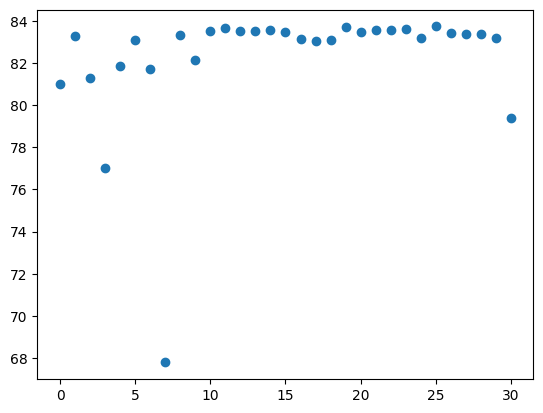

In [ ]:
print(accLst)
import matplotlib.pyplot as plt
plt.plot(list(range(31)), accLst[1:],linestyle="",marker="o")


In [ ]:
[print(line) for line in loss]

0.615612
0.358674
0.25942
0.150287
0.138939
0.168192
0.137491
0.106759
0.074517
0.068448
0.060822
0.064941
0.056588
0.061876
0.056639
0.058976
0.054406
0.058531
0.053531
0.055196
0.054282
0.053187
0.054858
0.051208
0.053481
0.051711
0.050393
0.048802
0.048471
0.050017
0.047468
0.04827
0.046977
0.048049
0.047236
0.04749
0.047437
0.046915
0.047225
0.044697
0.045507
0.045685
0.044754
0.044695
0.046117
0.044075
0.045959
0.046103
0.048894
0.050479


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
# @title Cleanup
# Due to Python memory management this might be needed to clean gpu cache (even a few times)
# Please ignore error 'model' is not defined

torch.cuda.empty_cache()
gc.collect()
#!nvidia-smi #prints out stats

del model

NameError: name 'torch' is not defined

### Heatmap Sandboxing

In [ ]:
#model = TwinCNN(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
#model.load_state_dict(torch.load(tempPath + '/model_TwinCNN.pth'))



<ipython-input-123-644e5121eaff>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinCNN.pth'))


RuntimeError: Error(s) in loading state_dict for TwinCNN:
	Unexpected key(s) in state_dict: "convs_1d.3.weight", "convs_1d.3.bias", "convs_1d.4.weight", "convs_1d.4.bias", "convs_1d.5.weight", "convs_1d.5.bias", "convs_1d.6.weight", "convs_1d.6.bias", "convs_1d.7.weight", "convs_1d.7.bias". 
	size mismatch for fcB.weight: copying a param with shape torch.Size([150, 800]) from checkpoint, the shape in current model is torch.Size([150, 300]).
	size mismatch for fcA.weight: copying a param with shape torch.Size([150, 800]) from checkpoint, the shape in current model is torch.Size([150, 300]).
	size mismatch for fcM.weight: copying a param with shape torch.Size([150, 800]) from checkpoint, the shape in current model is torch.Size([150, 300]).

In [ ]:
print(model)

TwinCNN(
  (embedTwin): Embedding(35576, 128)
  (embedMsg): Embedding(80831, 128)
  (convs_1d): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 128), stride=(1, 1), padding=(1, 0))
    (1): Conv2d(1, 100, kernel_size=(4, 128), stride=(1, 1), padding=(2, 0))
    (2): Conv2d(1, 100, kernel_size=(5, 128), stride=(1, 1), padding=(3, 0))
  )
  (norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fcB): Linear(in_features=300, out_features=150, bias=True)
  (fcA): Linear(in_features=300, out_features=150, bias=True)
  (fcM): Linear(in_features=300, out_features=150, bias=True)
  (fc): Linear(in_features=450, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=2, bias=True)
  (sig): Sigmoid()
)


a
a
a
a
a
a


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


a
a
a
a
a
a
a
a
a
a
a
a


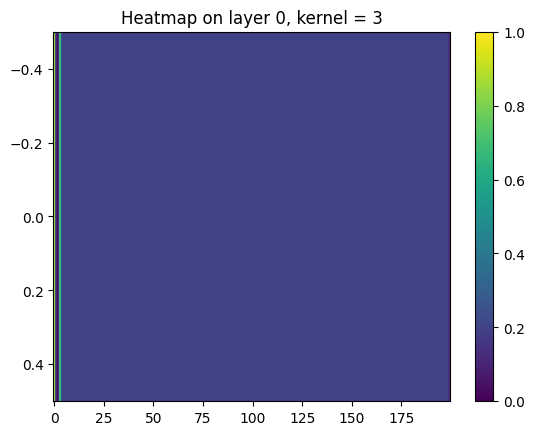

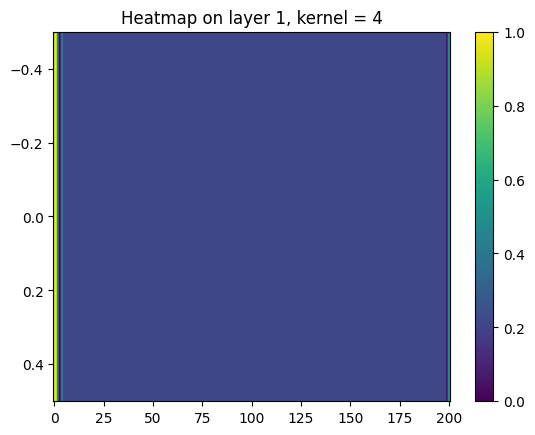

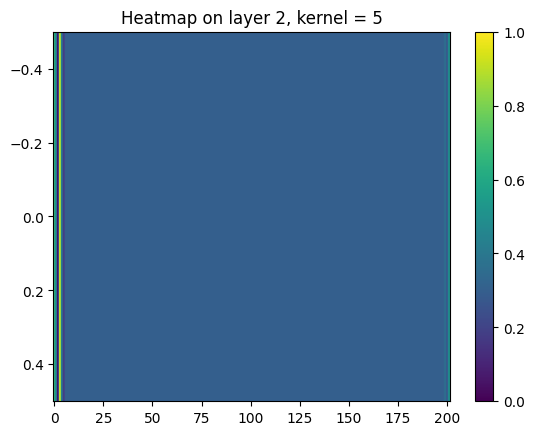

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Function

# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Register hooks
        self.forwardHook=self.target_layer.register_forward_hook(self.save_activations)
        self.backwardHook=self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        print("a")
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_data, classid=None):
        # Forward pass
        self.model.eval()
        output = self.model.forward(input_data)
        if classid is None:
            classid = torch.argmax(output, dim=1)
        #print(input_data.shape)
        #print(output.shape)

        # Backward pass for target class
        self.model.zero_grad()
        target = output[:, classid]
        target.backward()

        self.model.train()
        # Grad-CAM computation
        #print(self.gradients.shape)
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        #print(f"Weights: {weights.shape}")
        #print(f"Activations {self.activations.shape}")
        #print(f"(weights * self.activations) {(weights * self.activations).shape}")
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.sigmoid(cam)
        #print(cam.shape)
        # Normalize and return heatmap
        cam = cam - cam.min()
        cam = cam / cam.max()
        #print(cam.shape)
        cam = cam.squeeze(dim=1).detach().cpu().numpy()
        #print(cam.shape)
        return cam

    def Clean(self):
        self.forwardHook.remove()
        self.backwardHook.remove()

def getDataAndClass(data,labels,id):
  return torch.from_numpy(data[id]).unsqueeze(0), labels[id]

def generate_heatmap_for_layer(layer, input, classid):
  target_layer = layer # Select the first convolutional layer
  grad_cam = GradCAM(model, target_layer)
  class_idx = labelTrain[0]  # Target class (adjust based on your model output)
  heatmap = grad_cam.generate_heatmap(input_data, classid)
  grad_cam.Clean()
  return heatmap

# Generate heatmaps
input_data, real_class = getDataAndClass(dataTrain,labelTrain,0)
l0heatmap = generate_heatmap_for_layer(model.convs_1d[0],input_data,real_class)
l1heatmap = generate_heatmap_for_layer(model.convs_1d[1],input_data,real_class)
l2heatmap = generate_heatmap_for_layer(model.convs_1d[2],input_data,real_class)

# Display the heatmaps
plt.title("Heatmap on layer 0, kernel = 3")
plt.imshow(l0heatmap, cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()

plt.title("Heatmap on layer 1, kernel = 4")
plt.imshow(l1heatmap, cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()

plt.title("Heatmap on layer 2, kernel = 5")
plt.imshow(l2heatmap, cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()

def generateUpscaledHeatmap(heatmap):
  heatmap_tensor = torch.from_numpy(heatmap).unsqueeze(0)  # Add batch and channel dims
  upsampled_heatmap = F.interpolate(heatmap_tensor, size=(800, 1), mode='bilinear', align_corners=False)
  upsampled_heatmap = upsampled_heatmap.squeeze(0).numpy()
  return upsampled_heatmap

ul0heatmap = generateUpscaledHeatmap(l0heatmap)
ul1heatmap = generateUpscaledHeatmap(l1heatmap)
ul2heatmap = generateUpscaledHeatmap(l2heatmap)

#plt.figure(figsize=(10, 5))
#print(f"input shape {input_data[:,:,0].shape}")
#plt.imshow(input_data[:,:,0], aspect='auto', cmap='Blues', alpha=0.8)  # Input data visualization
#plt.imshow(upsampled_heatmap, aspect='auto', cmap='Reds', alpha=0.5)  # Overlay heatmap
#plt.colorbar()
#plt.show()

In [ ]:
# @title Here we can color the text
from matplotlib import cm
from matplotlib.colors import Normalize
from IPython.display import HTML
from IPython.core.display import display

def printHeatmapOnSequence(sequence,heatmap):
  def decode(seq):
    x = []
    diffDict = GetDiffDict(diffVocab)
    def find(dic,val):
      for k,v in diffDict.items():
        if(v == val):
          return k
      return None
    for item in seq:
      x.append(find(diffDict,item))
    return x

  seq = sequence.squeeze(0).numpy()

  text_tokens = decode(seq)
  print(''.join(text_tokens))

  # Normalize heatmap
  heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

  # Define colormap
  colormap = cm.get_cmap('Blues')
  norm = Normalize(vmin=0, vmax=1)
  colors = colormap(norm(heatmap.squeeze()))

  # Create HTML with colored tokens
  colored_text = []
  for token, rgba in zip(text_tokens, colors):
      r, g, b, _ = rgba
      color = f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"
      colored_text.append(f'<span style="background-color:{color}">{token}</span>')

  # Display in Jupyter Notebook
  html_output = ' '.join(colored_text)

  return html_output

#print(input_data[:,:,0].squeeze(0).numpy())
display(HTML("Layer 0: "+printHeatmapOnSequence(input_data[:,:,0],ul0heatmap)))
display(HTML("Layer 1: "+printHeatmapOnSequence(input_data[:,:,0],ul1heatmap)))
display(HTML("Layer 2: "+printHeatmapOnSequence(input_data[:,:,0],ul2heatmap)))

[INFO] <GetDiffDict> Create dictionary for 35576 diff vocabulary tokens. (with '<pad>')
if(VAR0==0){VAR0=FUNC0(VAR1,&VAR2->VAR3,VAR4,VAR5=FUNC1(VAR5));}}if(VAR0)FUNC3(VAR2,FUNC4(LITERAL,VAR0,VAR0>1?LITERAL:LITERAL));if(VAR2->VAR3)<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

<ipython-input-137-7ce1709caef9>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


[INFO] <GetDiffDict> Create dictionary for 35576 diff vocabulary tokens. (with '<pad>')
if(VAR0==0){VAR0=FUNC0(VAR1,&VAR2->VAR3,VAR4,VAR5=FUNC1(VAR5));}}if(VAR0)FUNC3(VAR2,FUNC4(LITERAL,VAR0,VAR0>1?LITERAL:LITERAL));if(VAR2->VAR3)<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

[INFO] <GetDiffDict> Create dictionary for 35576 diff vocabulary tokens. (with '<pad>')
if(VAR0==0){VAR0=FUNC0(VAR1,&VAR2->VAR3,VAR4,VAR5=FUNC1(VAR5));}}if(VAR0)FUNC3(VAR2,FUNC4(LITERAL,VAR0,VAR0>1?LITERAL:LITERAL));if(VAR2->VAR3)<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [ ]:
#Creating a 3d heatmap

### Decoding sandboxing

In [ ]:
# @title Sandboxing
print(dataTrain[0].shape)
diffDict = GetDiffDict(diffVocab)
for item in diffDict:
  if("VAR" not in item and "FUNC" not in item):
    print(item)



In [ ]:
def decode(seq):
  x = []
  diffDict = GetDiffDict(diffVocab)
  def find(dic,val):
    for k,v in diffDict.items():
      if(v == val):
        return k
    return None
  for item in seq:
    x.append(find(diffDict,item))
  return x

In [ ]:
itemid=1
dataItem = dataTrain[itemid][:,0]
tokenType = [str(np.argmax(d)) for d in dataTrain[itemid][:,1:5]]
decoded = decode(dataItem)
encoded = [str(d) for d in dataItem]
print(''.join(decoded))
print(','.join(encoded))
print(','.join(tokenType))

[INFO] <GetDiffDict> Create dictionary for 35576 diff vocabulary tokens. (with '<pad>')
gotoVAR0;}VAR1=(unsignedlong*)FUNC0(VAR2);FUNC1(VAR3,LITERAL,VAR4);FUNC1(VAR5,LITERAL,VAR4);<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [ ]:
for i in range(len(dataTrain)):
  if(dataTrain[i][:,5].sum()>0):
    print(i)
    break

0


In [ ]:
from tabulate import tabulate
zipped = [[k,v] for k,v in zip(decoded,encoded)]
zipped
print(tabulate(zipped, headers=['Decoded', 'Encoded']))

Decoded      Encoded
---------  ---------
FUNC0             12
(                  2
unsigned         423
long             424
VAR0               4
,                 38
unsigned         423
long             424
VAR1               6
,                 38
struct            52
VAR2               8
*                  3
VAR3              28
,                 38
void              42
*                  3
*                  3
VAR4              37
)                  9
{                 10
unsigned         423
long             424
*                  3
VAR5              39
=                 21
(                  2
long             424
*                  3
)                  9
VAR4              37
;                 26
if                11
(                  2
!                 44
*                  3
VAR5              39
)                  9
return            35
;                 26
if                11
(                  2
*                  3
VAR5              39
!=                47
-            

In [ ]:
def TransformPatch2Imgs(sequence): #sequence 800x5
  bf = sequence[:,0:5]
  b = np.zeros((800,5))
  for i in range(len(bf)):
    itemValue = bf[i][0]
    itemChannel = np.argmax(bf[i][1:6])
    b[i][itemChannel] = itemValue
  b = b.reshape((20,40,5))
  af = sequence[:,6:]
  a = np.zeros((800,5))
  for i in range(len(af)):
    itemValue = af[i][0]
    itemChannel = np.argmax(af[i][1:6])
    a[i][itemChannel] = itemValue
  a = a.reshape((20,40,5))

  c = np.zeros((40,40,5))
  iter = 0
  for i in range(0,20):
    c[iter]=b[i]
    c[iter+1]=a[i]
    iter = iter +2

  return b,a,c #20x40x5 #h,w,c
before, after, concatenated = TransformPatch2Imgs(dataTrain[itemid])

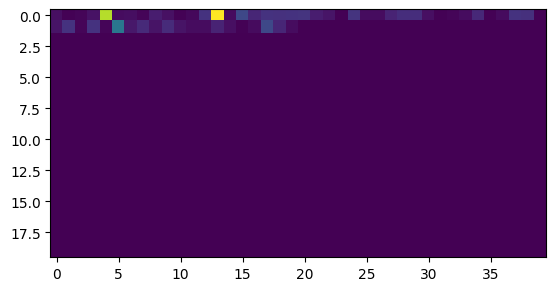

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(before.sum(axis=2), interpolation='nearest')

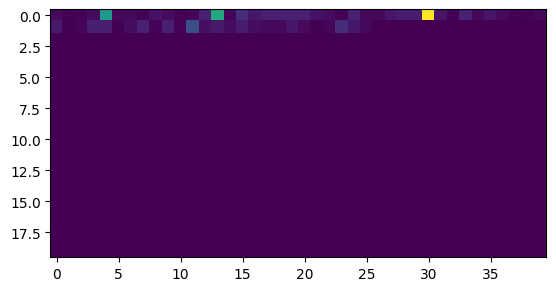

In [ ]:
plt.imshow(after.sum(axis=2), interpolation='nearest')

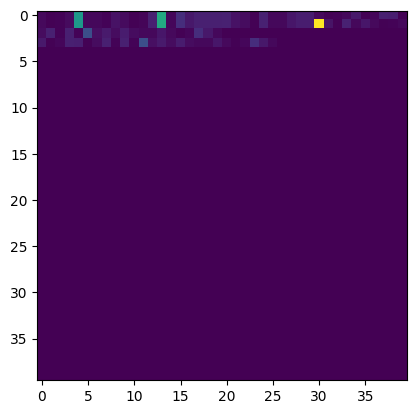

In [ ]:
plt.imshow(concatenated.sum(axis=2), interpolation='nearest')

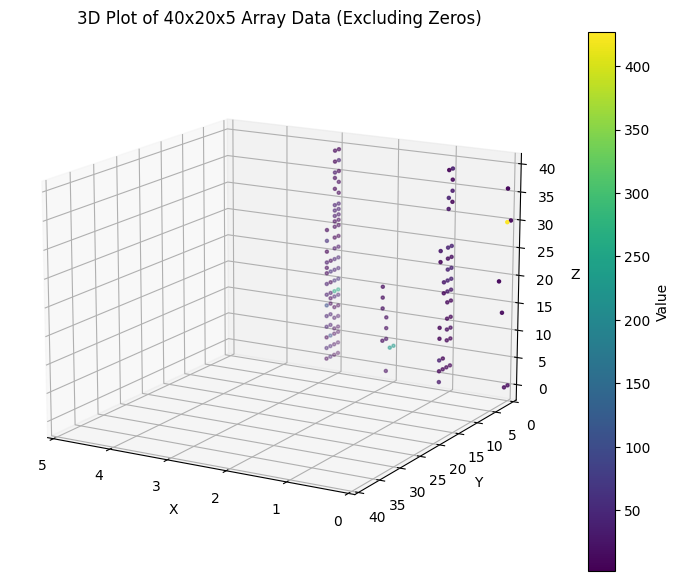

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(data,cmap='viridis'):
  # Create a grid of coordinates (x, y, z) for plotting
  x = np.arange(data.shape[0])
  y = np.arange(data.shape[1])
  z = np.arange(data.shape[2])

  # Create meshgrid for 3D plotting
  X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

  # Flatten the arrays for scatter plot
  X_flat = X.flatten()
  Y_flat = Y.flatten()
  Z_flat = Z.flatten()
  data_flat = data.flatten()

  # Mask out zero values
  non_zero_mask = data_flat != 0
  X_filtered = X_flat[non_zero_mask]
  Y_filtered = Y_flat[non_zero_mask]
  Z_filtered = Z_flat[non_zero_mask]
  data_filtered = data_flat[non_zero_mask]

  # Plotting
  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')

  # Scatter plot excluding zeros
  scatter = ax.scatter(X_filtered, Y_filtered, Z_filtered, c=data_filtered, cmap=cmap,s=5)
  fig.colorbar(scatter, ax=ax, label='Value')

  # Labels
  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Z")
  plt.title("3D Plot of 40x20x5 Array Data (Excluding Zeros)")
  ax.set_xticks(np.arange(data.shape[2]))
  ax.view_init(elev=15, azim=120)
  ax.set_xlim(0, 5)
  ax.set_ylim(0, 40)
  ax.set_ylim(0, 40)

  plt.show()
plot3d(torch.tensor(concatenated).permute(2,0,1))

In [ ]:
def applyheatmapto3dinput(data,heatmap):
  h = heatmap.reshape((20,40))
  val = data.copy()
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      for k in range(data.shape[2]):
        if val[i][j][k] != 0:
          #print(val[i][j][k],h[i][j])
          val[i][j][k] = h[i][j]
  return val


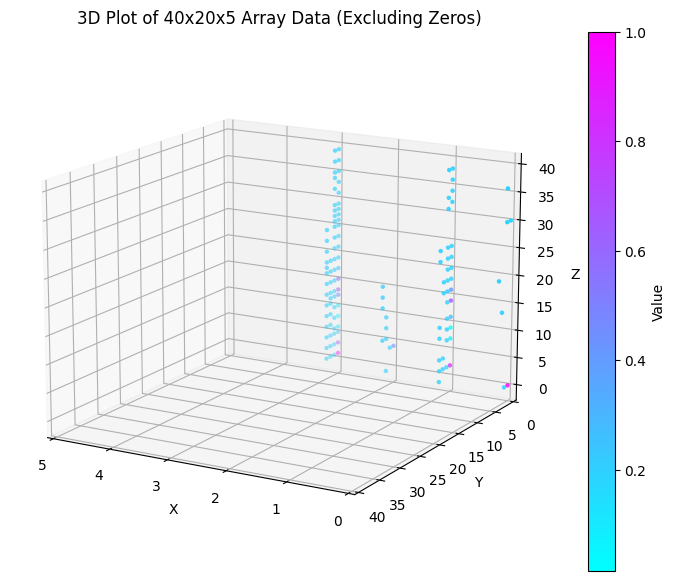

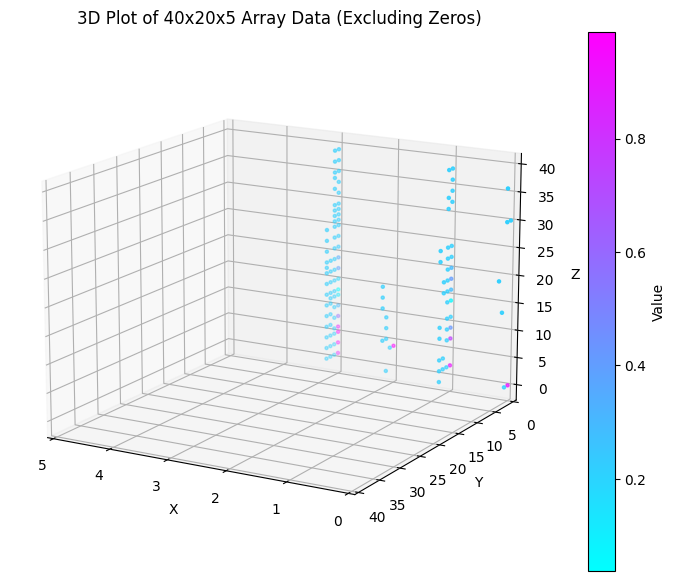

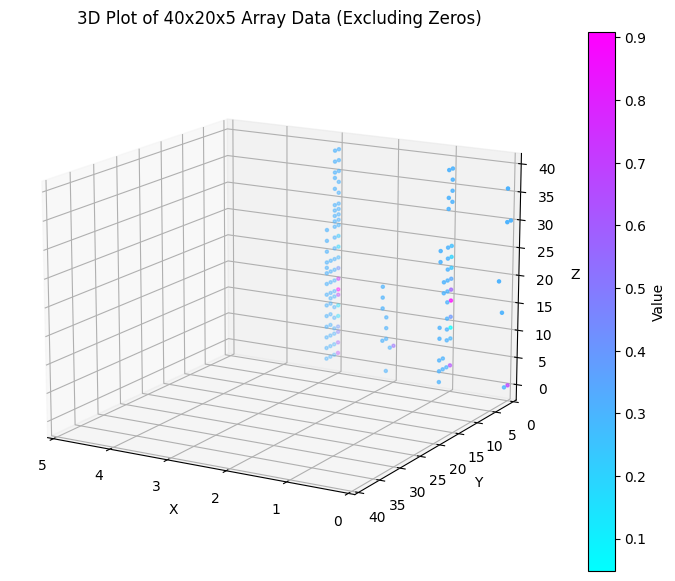

In [ ]:
#Displays a heatmap in 3d format
heatmap3d = applyheatmapto3dinput(concatenated, ul0heatmap)
plot3d(torch.tensor(heatmap3d).permute(2,0,1),cmap='cool')
heatmap3d = applyheatmapto3dinput(concatenated, ul1heatmap)
plot3d(torch.tensor(heatmap3d).permute(2,0,1),cmap='cool')
heatmap3d = applyheatmapto3dinput(concatenated, ul2heatmap)
plot3d(torch.tensor(heatmap3d).permute(2,0,1),cmap='cool')